# Predicting Home Prices in Philadelphia

For this project we are assuming the role of real estate investors in Philadelphia. Our goal is to find the 5 best zipcodes to invest in.  Specifically, we will be looking for the zipcodes with the highest return on investment (ROI), while attempting to mitigate risk. Our investment period will be mostly short term (1-3 years) as we are interested in keeping our assets as fluid as possible. The data for this project comes from zillow.com and is comprised of the median home price for each zipcode in the US from April 1996 until April 2018.  We will trim this data down to all of the zipcodes in Philadelphia, PA and create ARIMA models to forecast future prices. From there we will take an in-depth look at the zipcodes with the best ROI's and attempt to gauge the risk in investing in those zipcodes.


# Step 1: Load Relevant Libraries, Define Helper Functions, and Load Data

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
sns.set_style('darkgrid')
%matplotlib inline

import statsmodels.api as sm
import itertools
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose as sd
from math import sqrt
from sklearn.metrics import mean_squared_error as MSE

import warnings
warnings.filterwarnings('ignore')

In [1]:
def get_datetimes(df):
    '''
    Converts dates used as column names into datetimes.

    Parameters:
    df: The dataframe with dates as columns.

    Returns:
    Dataframe with datetimes as columns.
    ''' 
    return pd.to_datetime(df.columns[1:].values, format='%Y-%m')

def melt_data(df):
    '''
    Transforms a df from wide format to long format.

    Parameters:
    df: A wide format dataframe

    Returns:
    A long format dataframe
    '''
    melted = pd.melt(df, id_vars=['RegionName'], var_name='time')
    melted['time'] = pd.to_datetime(melted['time'], infer_datetime_format=True)
    melted = melted.dropna(subset=['value'])
    return melted

def ts_plotter(ind):
    '''
    Retrieves a time series from a list and produces several plots.

    Parameters:
    ind: list index of time series to be plotted

    Returns:
    Graph of time series, ACF and PACF of time series, graph of time series differencd twice, 
    graph of differenced time series' ACF and PACF.
    '''
    # Select time series
    zc = time_series[ind].RegionName.values[0]
    ts = time_series[ind].value

    roll_mean = ts.rolling(window=12, center=False).mean()

    # Plot time series with rolling mean
    fig1 = plt.figure(figsize=(10,6))
    ts.plot(label='Home Values')
    roll_mean.plot(color='red', linestyle='--', label='Rolling Mean')
    plt.title('Median Home Value for Zip Code {}'.format(zc))
    plt.ylabel('Value')
    plt.xlabel('Date')
    plt.legend()
    plt.show()
    
    # Plot ACF and PACF
    fig2,(ax1,ax2) = plt.subplots(2,1,figsize=(13,8))
    plot_acf(ts.dropna(), lags=24, ax=ax1)
    plot_pacf(ts.dropna(), lags=24, ax=ax2)
    plt.show()
    
    # Plots differenced Time Series
    fig3 = plt.figure(figsize=(10,6))
    ts_diff = ts.diff().diff().dropna()
    roll_mean = ts_diff.rolling(window=12, center=False).mean()
    roll_std = ts_diff.rolling(window=12, center=False).std()
    fig3 = plt.figure(figsize=(10,6))
    ts_diff.plot(label='Differenced Value')
    roll_mean.plot(color='red', linestyle='--', label='Rolling Mean')
    roll_std.plot(color='black', linestyle='-.', label='Rolling STD')
    plt.title('Differenced Median Home Value')
    plt.legend()
    plt.ylabel('Value')
    plt.xlabel('Date')
    plt.show()
    
    fig4,(ax1,ax2) = plt.subplots(2,1,figsize=(13,8))
    plot_acf(ts_diff, lags=24, ax=ax1)
    plot_pacf(ts_diff, lags=24, ax=ax2)
    plt.show()
    
    # returns the time series
    return ts, zc

def plot_seasonality(ts):
    '''
    Plots the seasonality of a time series.

    Parameters:
    ts: Time series to be decomposed.

    Returns:
    Graph of seasonality of time series.
    '''
    seasonal = sd(ts).seasonal
    fig = plt.figure(figsize=(8,3))
    plt.plot(seasonal, label='Seasonality', color="blue")
    plt.legend(loc='best')
    plt.show()

def find_p_and_q(ts, verbose=True):
    '''
    Function to find optimal order by AIC for ARIMA model.

    Parameters:
    ts: Time series to be modeled.
    verbose: If true, prints optimal order.

    Returns:
    Optimal pdq order.
    '''
    p = range(5)
    d = [2]
    q = range(5)
    pdq = list(itertools.product(p, d, q))
    
    # Next we run each combination through an arima model and record the AIC
    AICs = []
    for comb in pdq:
        try:
            model = ARIMA(ts, order=comb, enforce_stationarity=True, enforce_invertibility=True)
            output = model.fit()
            AICs.append([comb, output.aic])
        except:
            # need to have a fail safe in case the arima won't converge
            pass
    AIC_df = pd.DataFrame(AICs, columns=['pdq', 'AIC'])
    if verbose:
        # prints the pdq combination with lowest AIC
        print(AIC_df.loc[AIC_df.AIC.idxmin()][0])
    # returns the pdq combination with lowest AIC  

    return AIC_df.loc[AIC_df.AIC.idxmin()][0]
    
    
def model_and_fit(ts, order, verbose=True):
    '''
    Splits data into train and fit categories, then fits an ARIMA model

    Parameters:
    ts: Time series to be modeled.
    order: pdq order for ARIMA model.
    verbose: If true, displays model statistics

    Returns:
    train: Training data.
    test: Testing data.
    results: Fitted ARIMA model.
    '''
    # Separates the time series into training and testing data
    train = ts[:'2016-10-01']
    test = ts['2016-10-01':]
    # builds a model and trains it on the training set
    model = ARIMA(train, order= order, enforce_stationarity=True, enforce_invertibility=True)
    results = model.fit()
    if verbose:
        # Displays model results
        print(results.summary())
        results.plot_diagnostics(figsize=(10,8))
        plt.show()

    
    return train, test, results

def train_error(train, model):
    '''
    Plots training data and training predictions

    Parameters:
    train: Training data
    model: Fitted ARIMA model

    Returns:
    A graph of the training data and predictions
    '''
    train_pred = model.get_prediction(start=11)
    rmse = sqrt(MSE(train[11:], train_pred.predicted_mean))
    print(f'ARIMA model RMSE on train data: %.5f' % rmse)

    fig = plt.figure(figsize=(13,6))
    train.plot(label='Actual',color='b')
    train_pred.predicted_mean.plot(label='predicted', color='red')
    plt.legend(loc='best')
    plt.title('Actual Train Data vs. Predicted Returns')
    plt.xlabel("Date")
    plt.ylabel("Price")
    plt.show()

def test_error(ts, test, model):
    '''
    Plots a time series and predictions for test data.

    Parameters:
    ts: Original time series.
    test: Testing data.
    model: Fitted ARIMA model

    Returns:
    A graph of the entire time series with predictions for testing data and confidence intervals.
    rmse: Root mean square error of the predictions.
    '''
    test_pred = model.get_prediction(start = pd.to_datetime('2016-10-01'), end=(pd.to_datetime('2018-04-01')), dynamic=True)
    pred_conf = test_pred.conf_int()
    rmse = sqrt(MSE(test, test_pred.predicted_mean))
    print(f'ARIMA model RMSE on test data: %.5f' % rmse)

    plt.figure(figsize=(13,6))
    ts.plot(label='Actual',color='blue')
    test_pred.predicted_mean.plot(label='predicted', color='red')
    plt.fill_between(pred_conf.index,
                pred_conf.iloc[:, 0],
                pred_conf.iloc[:, 1], color='g', alpha=0.25)

    plt.legend(loc='best')
    plt.title('Actual Test Data vs. Predicted Returns')
    plt.ylabel('Price')
    plt.xlabel('Date')
    plt.show()
    # returns the rmse of the test data
    return rmse
    
def forecast(ts, order, graph=True):
    '''
    Predicts home prices for 3 years.

    Parameters:
    ts: Time series to be predicted.
    order: pdq order for ARIMA model
    graph: If true, plots a graph of the time series and the predictions with confidence intervals.

    Returns:
    roi1: Return on investment for 1 year.
    roi2: Return on investment for 2 years.
    roi3: Return on investment for 3 years.
    risk1: Risk estimate at 1 year.
    risk2: Risk estimate at 2 years.
    risk3: Risk estimate at 3 years.
    '''
    # Predicts home prices for five years. If graph=true, plots the time series and predictions
    model = ARIMA(ts, order=order, enforce_stationarity=True, enforce_invertibility=True)
    result = model.fit()
    prediction = result.get_forecast(36)
    pred_conf = prediction.conf_int()
    current_price = ts[-1]
    
    returns1 = (prediction.predicted_mean[11] - current_price)
    returns2 = (prediction.predicted_mean[23] - current_price)
    returns3 = (prediction.predicted_mean[-1] - current_price)
    
    roi1 = returns1/ current_price 
    roi2 = returns2/ current_price
    roi3 = returns3/ current_price
    
    risk1 = (current_price - pred_conf.iloc[11,0]) / (pred_conf.iloc[11,1] - pred_conf.iloc[11,0])
    risk2 = (current_price - pred_conf.iloc[23,0]) / (pred_conf.iloc[23,1] - pred_conf.iloc[23,0])
    risk3 = (current_price - pred_conf.iloc[-1,0]) / (pred_conf.iloc[-1,1] - pred_conf.iloc[-1,0])
    

    if graph:
        fig = plt.figure(figsize=(15,6))
        ts.plot(label='observed')
        prediction.predicted_mean.plot(label='predicted')
        plt.fill_between(pred_conf.index, pred_conf.iloc[:, 1], current_price, color='g', alpha=0.25)
        plt.fill_between(pred_conf.index, pred_conf.iloc[:, 0], current_price, color='r', alpha=0.25)
        plt.title("Forecast Prices for 3 Years")
        plt.legend(loc='best')
        plt.xlabel('Date')
        plt.ylabel('Price')
        plt.show()
    
    # Returns Rate of return for 1 year, 3 years, and 5 years
    return roi1, roi2, roi3, risk1, risk2, risk3

def ts_processor(ind):
    '''
    Models a time series from start to finish using several other functions.

    Parameters:
    ind: List index of time series to be modeled.

    Returns:
    ts: Time series
    '''
    # combines several functions to fully process a time series
    ts, zc = ts_plotter(ind)
    plot_seasonality(ts)
    pdq = philly_results['pdq'][ind]
    train, test, model = model_and_fit(ts, pdq)
    train_error(train, model)
    rmse = test_error(ts, test, model)
    roi1, roi2, roi3, risk1, risk2, risk3 = forecast(ts, pdq)
    print("Returns after 1, 2, 3 years: {}%, {}%, {}%".format(round(roi1, 2)*100, 
                                                              round(roi2, 2)*100, 
                                                              round(roi3, 2)*100))
    print("Risk after 1, 2, 3 years: {}%, {}%, {}%".format(round(risk1, 2)*100, 
                                                           round(risk2, 2)*100, 
                                                           round(risk3, 2)*100))

    return ts


In [3]:
data = pd.read_csv('zillow_data.csv')
data.head()

,RegionID,RegionName,City,State,Metro,CountyName,SizeRank,1996-04,1996-05,1996-06,...,2017-07,2017-08,2017-09,2017-10,2017-11,2017-12,2018-01,2018-02,2018-03,2018-04
0,84654,60657,Chicago,IL,Chicago,Cook,1,334200.0,335400.0,336500.0,...,1005500,1007500,1007800,1009600,1013300,1018700,1024400,1030700,1033800,1030600
1,90668,75070,McKinney,TX,Dallas-Fort Worth,Collin,2,235700.0,236900.0,236700.0,...,308000,310000,312500,314100,315000,316600,318100,319600,321100,321800
2,91982,77494,Katy,TX,Houston,Harris,3,210400.0,212200.0,212200.0,...,321000,320600,320200,320400,320800,321200,321200,323000,326900,329900
3,84616,60614,Chicago,IL,Chicago,Cook,4,498100.0,500900.0,503100.0,...,1289800,1287700,1287400,1291500,1296600,1299000,1302700,1306400,1308500,1307000
4,93144,79936,El Paso,TX,El Paso,El Paso,5,77300.0,77300.0,77300.0,...,119100,119400,120000,120300,120300,120300,120300,120500,121000,121500


Great! Our data is all loaded up.  Next, we will select the data for Philadelphia and start to explore it in more depth.

# Step 2: Zipcode Selection and Data Preprocessing

First, we will select the zipcodes in Philadelphia.

In [4]:
df = data.loc[(data.State == 'PA') & (data.City == 'Philadelphia')]
print(len(df), 'Zipcodes')
df.head()

35 Zipcodes


,RegionID,RegionName,City,State,Metro,CountyName,SizeRank,1996-04,1996-05,1996-06,...,2017-07,2017-08,2017-09,2017-10,2017-11,2017-12,2018-01,2018-02,2018-03,2018-04
194,65779,19111,Philadelphia,PA,Philadelphia,Philadelphia,195,84600.0,84500.0,84400.0,...,167100,168100,169300,170600,171900,172700,173200,174000,175200,175800
282,65791,19124,Philadelphia,PA,Philadelphia,Philadelphia,283,43100.0,43000.0,42900.0,...,79800,80900,82200,83000,83800,84300,84200,84900,86700,88200
354,65787,19120,Philadelphia,PA,Philadelphia,Philadelphia,355,46100.0,46100.0,46100.0,...,82400,84400,86200,87500,88300,88900,90100,91400,92200,92400
466,65801,19134,Philadelphia,PA,Philadelphia,Philadelphia,467,27600.0,27500.0,27500.0,...,39000,39100,39100,39600,40600,41600,42600,44000,45700,46600
518,65815,19148,Philadelphia,PA,Philadelphia,Philadelphia,519,41100.0,41100.0,41000.0,...,192000,194800,197300,198600,199700,201000,202000,203800,207400,210100


Now that we have all of our data, lets get rid of the columns that we won't be needing and change our dates into datetimes.

In [5]:
to_drop = ['RegionID', 'City', 'State', 'Metro', 'CountyName', 'SizeRank']
philly_zc = df.drop(to_drop, axis=1)

datetimes = get_datetimes(philly_zc)
dates = philly_zc.columns[1:]
philly_zc = philly_zc.rename(columns=dict(zip(dates, datetimes)))

print(len(philly_zc), "zipcodes in Philadelphia")
philly_zc.head()

35 zipcodes in Philadelphia


,RegionName,1996-04-01 00:00:00,1996-05-01 00:00:00,1996-06-01 00:00:00,1996-07-01 00:00:00,1996-08-01 00:00:00,1996-09-01 00:00:00,1996-10-01 00:00:00,1996-11-01 00:00:00,1996-12-01 00:00:00,...,2017-07-01 00:00:00,2017-08-01 00:00:00,2017-09-01 00:00:00,2017-10-01 00:00:00,2017-11-01 00:00:00,2017-12-01 00:00:00,2018-01-01 00:00:00,2018-02-01 00:00:00,2018-03-01 00:00:00,2018-04-01 00:00:00
194,19111,84600.0,84500.0,84400.0,84200.0,84100.0,84000.0,83800.0,83700.0,83600.0,...,167100,168100,169300,170600,171900,172700,173200,174000,175200,175800
282,19124,43100.0,43000.0,42900.0,42700.0,42500.0,42400.0,42300.0,42300.0,42300.0,...,79800,80900,82200,83000,83800,84300,84200,84900,86700,88200
354,19120,46100.0,46100.0,46100.0,46100.0,46000.0,45900.0,45900.0,45800.0,45700.0,...,82400,84400,86200,87500,88300,88900,90100,91400,92200,92400
466,19134,27600.0,27500.0,27500.0,27400.0,27400.0,27300.0,27300.0,27200.0,27200.0,...,39000,39100,39100,39600,40600,41600,42600,44000,45700,46600
518,19148,41100.0,41100.0,41000.0,40900.0,40700.0,40600.0,40500.0,40400.0,40400.0,...,192000,194800,197300,198600,199700,201000,202000,203800,207400,210100


Let's check for null values now.

In [6]:
sum(philly_zc.isna().sum())

0

Great, we don't need to worry about missing data.  Now we will turn our dataframe from wide format to long format and seperate the zipcodes into individual time series.

In [7]:
melted_df = melt_data(philly_zc).set_index('time')
melted_df.head()

,RegionName,value
time,,
1996-04-01,19111,84600.0
1996-04-01,19124,43100.0
1996-04-01,19120,46100.0
1996-04-01,19134,27600.0
1996-04-01,19148,41100.0


In [8]:
time_series = []
for zip_code in melted_df.RegionName.unique():
    time_series.append(melted_df[melted_df.RegionName == zip_code])
print(len(time_series), 'Zipcodes')
time_series[0].head()

35 Zipcodes


,RegionName,value
time,,
1996-04-01,19111,84600.0
1996-05-01,19111,84500.0
1996-06-01,19111,84400.0
1996-07-01,19111,84200.0
1996-08-01,19111,84100.0


Now we have a list which contains 35 time series, each representing a different zip code in Philadelphia.  Let's see what our data looks like.  To start we will graph the median and mean value of homes.

Text(0, 0.5, 'Price')

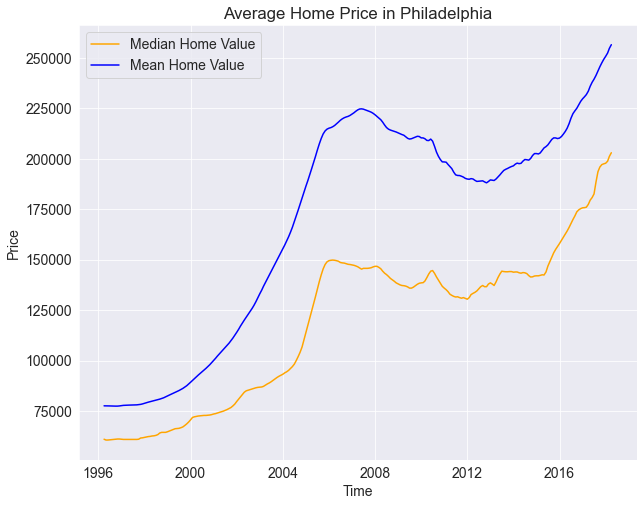

In [9]:
matplotlib.rcParams.update({'font.size': 14})
medians = []
means = []

for column in philly_zc.columns[1:]:
    medians.append(philly_zc[column].median())
    means.append(philly_zc[column].mean())
    
fig = plt.figure(figsize=(10,8))
plt.plot(datetimes, medians, color='orange', label='Median Home Value')
plt.plot(datetimes, means, color='blue', label='Mean Home Value')
plt.legend()
plt.title('Average Home Price in Philadelphia')
plt.xlabel('Time')
plt.ylabel('Price')

Now we have a benchmark for an average home price in Philadelphia. This will be important information for factoring risk later. Now, let's get a sense of the general shape of our zipcodes. This plot is not meant to make meaningful interpretations of individual zip codes, but more to gauge the general structure of our data.

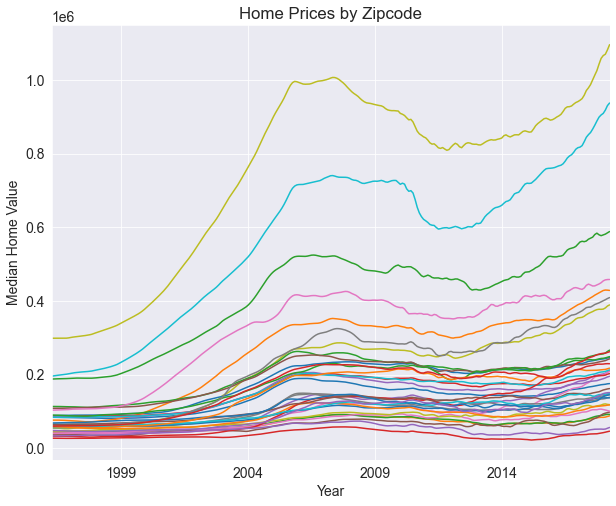

In [10]:
fig = plt.figure(figsize=(10,8))
for ts in time_series:
    ts.value.plot(label=ts.RegionName.values[0])
plt.xlabel('Year')
plt.ylabel('Median Home Value')
plt.title('Home Prices by Zipcode')
plt.show()

While this graph is not super helpful (it is extremely busy), it is useful to see that each time series take roughly the same shape.  I am concerned about the shape of the data, it seems to reflect the housing boom of the early 2000s and the collapse around 2009.  Let's try looking at the data from where it stabilizes (around 2011).

In [11]:
for ind in range(len(time_series)):
    time_series[ind] = time_series[ind]['2012':]

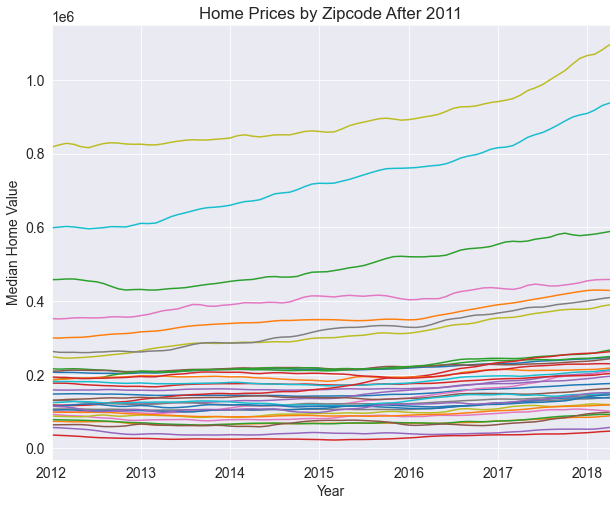

In [12]:
fig = plt.figure(figsize=(10,8))
for ts in time_series:
    ts.value.plot(label=ts.RegionName.values[0])
plt.xlabel('Year')
plt.ylabel('Median Home Value')
plt.title('Home Prices by Zipcode After 2011')
plt.show()

While this data looksa little flat, but it will expand once individual zip codes are inspected. The data looks good as a whole.  Let's check for stationarity now. We will use an adfuller test to check the stationarity of each time series. If the data is not stationary, we will difference it and check again. We will repeat this process until stationarity is reached. This will give us a rough idea of what our d value should be for our ARIMA.

In [13]:
for i in range(35):
    results = adfuller(time_series[i].value.dropna())
    print(f'ADFuller test p-value for zipcode: {time_series[i].RegionName.values[0]}')
    print('p-value:',results[1])
    if results[1]>0.05:
        print('Fail to reject the null hypothesis. Data is not stationary.\n')
    else:
        print('Reject the null hypothesis. Data is stationary.\n')

ADFuller test p-value for zipcode: 19111
p-value: 0.7082554235124968
Fail to reject the null hypothesis. Data is not stationary.

ADFuller test p-value for zipcode: 19124
p-value: 1.0
Fail to reject the null hypothesis. Data is not stationary.

ADFuller test p-value for zipcode: 19120
p-value: 0.7932550677539683
Fail to reject the null hypothesis. Data is not stationary.

ADFuller test p-value for zipcode: 19134
p-value: 0.9838434014642896
Fail to reject the null hypothesis. Data is not stationary.

ADFuller test p-value for zipcode: 19148
p-value: 0.9983023122362358
Fail to reject the null hypothesis. Data is not stationary.

ADFuller test p-value for zipcode: 19131
p-value: 0.5955080952472387
Fail to reject the null hypothesis. Data is not stationary.

ADFuller test p-value for zipcode: 19145
p-value: 0.9985665460395537
Fail to reject the null hypothesis. Data is not stationary.

ADFuller test p-value for zipcode: 19149
p-value: 0.9964812025424848
Fail to reject the null hypothesis. 

In [14]:
for i in range(35):
    #Perform adfuller test and drop NaN values created when calculating monthly returns.
    results = adfuller(time_series[i].value.diff().dropna())
    print(f'ADFuller test p-value for zipcode: {time_series[i].RegionName.values[0]}')
    print('p-value:',results[1])
    if results[1]>0.05:
        print('Fail to reject the null hypothesis. Data is not stationary.\n')
    else:
        print('Reject the null hypothesis. Data is stationary.\n')

ADFuller test p-value for zipcode: 19111
p-value: 0.39728654859371937
Fail to reject the null hypothesis. Data is not stationary.

ADFuller test p-value for zipcode: 19124
p-value: 0.4239396326077502
Fail to reject the null hypothesis. Data is not stationary.

ADFuller test p-value for zipcode: 19120
p-value: 0.34428960030985034
Fail to reject the null hypothesis. Data is not stationary.

ADFuller test p-value for zipcode: 19134
p-value: 0.3329246902982938
Fail to reject the null hypothesis. Data is not stationary.

ADFuller test p-value for zipcode: 19148
p-value: 0.376373006567488
Fail to reject the null hypothesis. Data is not stationary.

ADFuller test p-value for zipcode: 19131
p-value: 0.17403218925091068
Fail to reject the null hypothesis. Data is not stationary.

ADFuller test p-value for zipcode: 19145
p-value: 0.4933655598342366
Fail to reject the null hypothesis. Data is not stationary.

ADFuller test p-value for zipcode: 19149
p-value: 0.6822783817116869
Fail to reject the 

In [15]:
for i in range(35):
    #Perform adfuller test and drop NaN values created when calculating monthly returns.
    results = adfuller(time_series[i].value.diff().diff().dropna())
    print(f'ADFuller test p-value for zipcode: {time_series[i].RegionName.values[0]}')
    print('p-value:',results[1])
    if results[1]>0.05:
        print('Fail to reject the null hypothesis. Data is not stationary.\n')
    else:
        print('Reject the null hypothesis. Data is stationary.\n')

ADFuller test p-value for zipcode: 19111
p-value: 1.0733600164852283e-05
Reject the null hypothesis. Data is stationary.

ADFuller test p-value for zipcode: 19124
p-value: 4.1359738777620436e-18
Reject the null hypothesis. Data is stationary.

ADFuller test p-value for zipcode: 19120
p-value: 0.00011860511582029378
Reject the null hypothesis. Data is stationary.

ADFuller test p-value for zipcode: 19134
p-value: 0.0008335209706700809
Reject the null hypothesis. Data is stationary.

ADFuller test p-value for zipcode: 19148
p-value: 7.900295304762547e-07
Reject the null hypothesis. Data is stationary.

ADFuller test p-value for zipcode: 19131
p-value: 1.927276613541679e-08
Reject the null hypothesis. Data is stationary.

ADFuller test p-value for zipcode: 19145
p-value: 0.003982295008710768
Reject the null hypothesis. Data is stationary.

ADFuller test p-value for zipcode: 19149
p-value: 0.013695021538530614
Reject the null hypothesis. Data is stationary.

ADFuller test p-value for zipco

It looks like most of our data achieved stationarity when differenced twice.  I expect most of our d values will be 2 when modeling.

Next we will look at our first zipcode. Using a helper function (ts_plotter) we will plot the time series with its rolling mean, then look at the ACF and PACF. We will also plot the time series when it has been differenced twice and again look at the ACF and PACF.

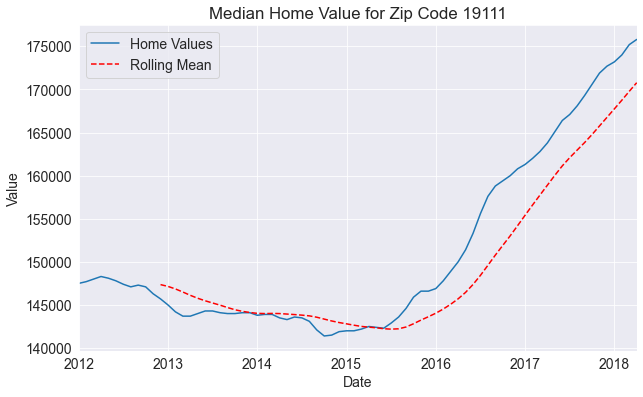

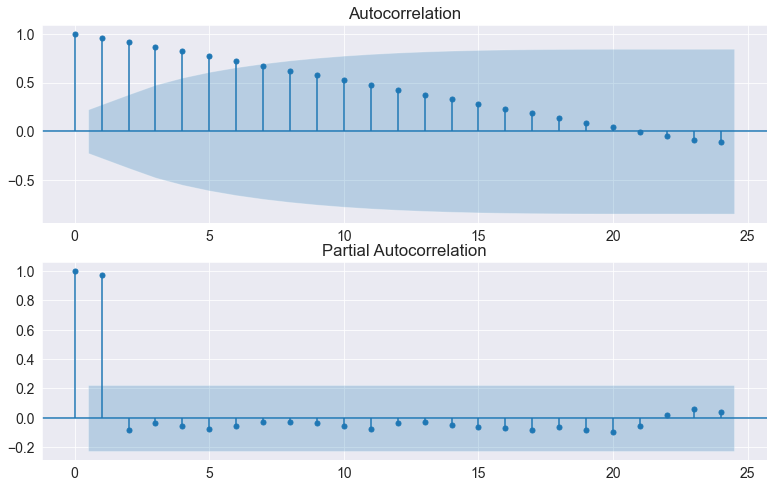

<Figure size 720x432 with 0 Axes>

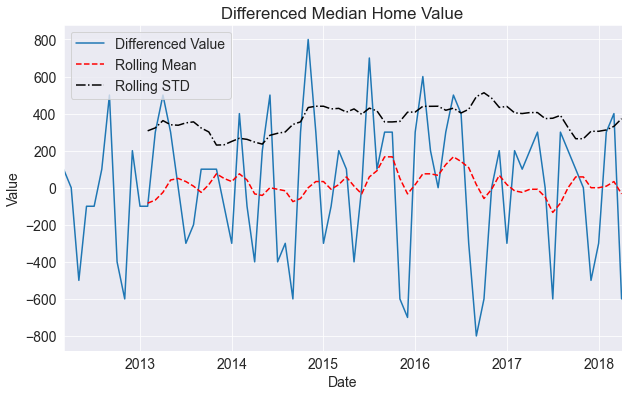

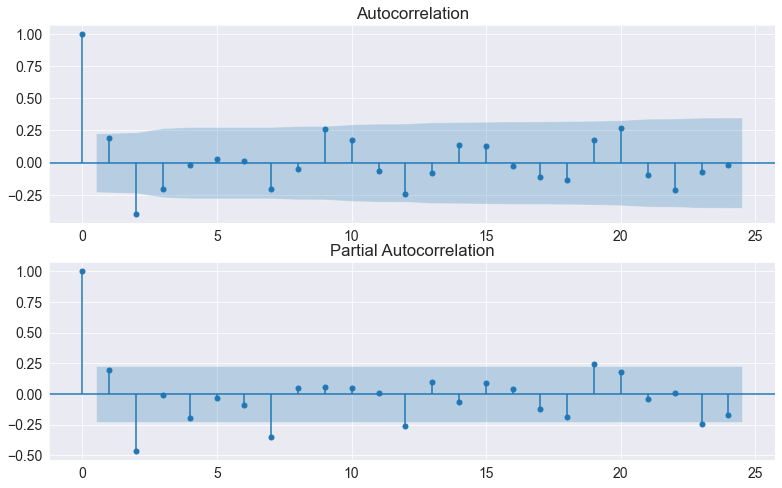

In [16]:
ts_19111, zc = ts_plotter(0)

As expected, there is heavy autocorrelation in the original time series. However, the differenced series is stationary and has good autocorrelation plots.  From these plots, I would estimate that our order for ARIMA will be close to (0, 2, 0) as the lags immediately become insignificant on the ACF and PACF. Before moving on to modeling, I will decompose the time series to check for seasonality.

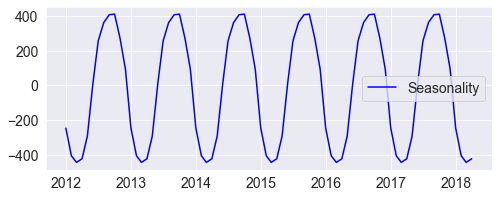

In [17]:
plot_seasonality(ts_19111)

There is very little seasonality present (oscillations of 800, when the price of home is over 140,000), so I am comfortable running ARIMA instead of SARIMA here. 

# Step 3: ARIMA Modeling

I think we are ready to start modeling our first time series. To start, we will find an optimized pdq order using a helper function (find_p_and_q). The function will return the order with the lowest AIC, resulting in, hopefully, the best fit.

In [18]:
pdq = find_p_and_q(ts_19111)

(0, 2, 0)


Looks like we will end up using (0, 2, 0) to start with. Now, we will split the time series into training and testing sets and fit our model to our training data using another helper function. Our test set will be the last year and a half of observations, as that is close to 20% of our data.

                               SARIMAX Results                                
Dep. Variable:                  value   No. Observations:                   58
Model:                 ARIMA(0, 2, 0)   Log Likelihood                -411.029
Date:                Tue, 24 Nov 2020   AIC                            824.057
Time:                        13:41:30   BIC                            826.083
Sample:                    01-01-2012   HQIC                           824.842
                         - 10-01-2016                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2      1.388e+05    3.2e+04      4.335      0.000     7.6e+04    2.01e+05
Ljung-Box (L1) (Q):                   4.00   Jarque-Bera (JB):                 1.22
Prob(Q):                              0.05   Pr

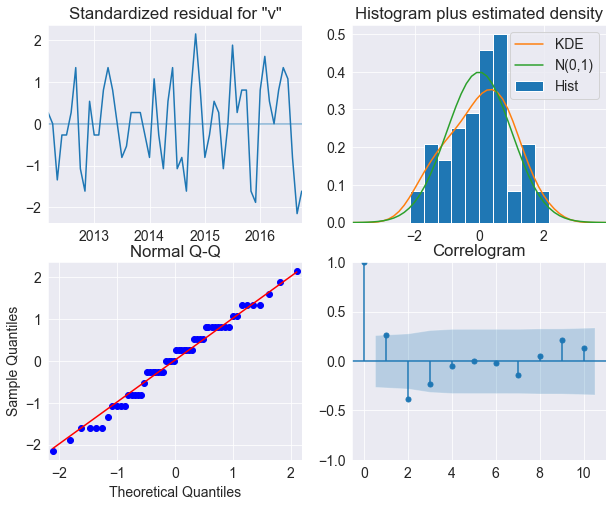

In [19]:
train, test, results = model_and_fit(ts_19111, order=pdq)

The Q-Q plot shows our residuals to not be normally distributed, and the histogram shows a left skew. There is no evidence of autocorrelation though, and the residuals look stationary. Overall, I would say the model is decently fit to the data. Let's look at how well our model predicts on the training and test sets.

ARIMA model RMSE on train data: 378.12527


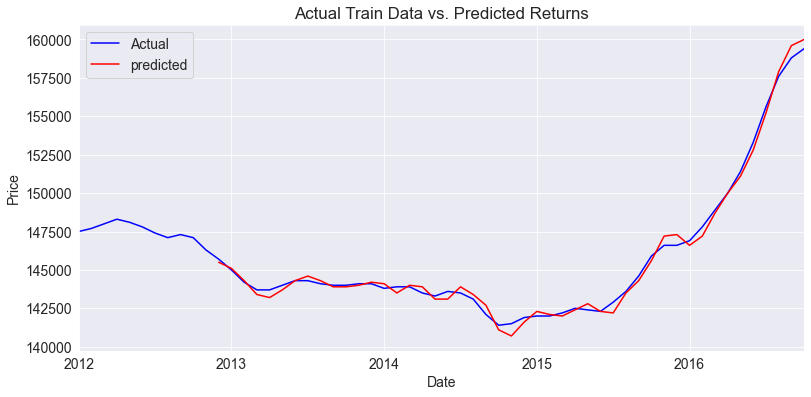

In [20]:
train_error(train, results)

ARIMA model RMSE on test data: 3700.85339


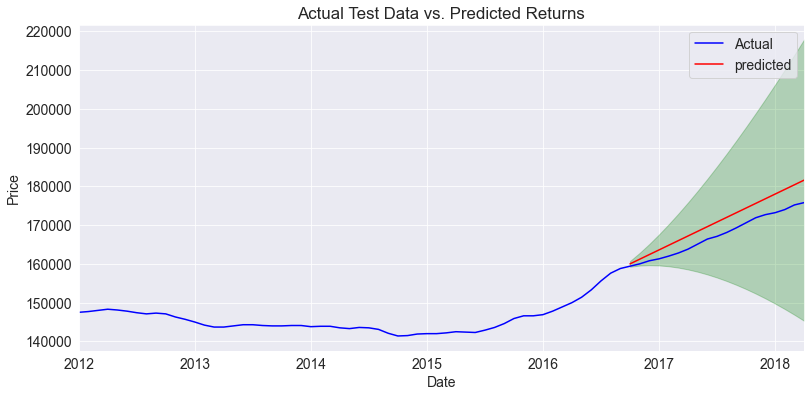

3700.853386649312

In [21]:
test_error(ts_19111, test, results)

The error values are pretty good and the actual values are easily within our confidence interval.  I'm satisfied with the model. Let's look at the predictions for the next 5 years.

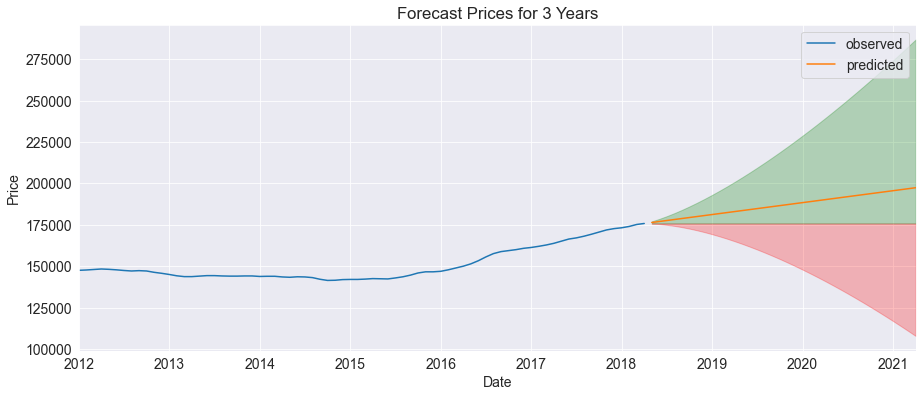

Return on investment after 1, 2, 3 years: 4.0%, 8.0%, 12.0%
Risk on investment after 1, 2, 3 years: 30.0%, 35.0%, 38.0%


In [22]:
roi1, roi2, roi3, risk1, risk2, risk3 = forecast(ts_19111, pdq)
print('Return on investment after 1, 2, 3 years: {}%, {}%, {}%'.format(round(roi1, 2)*100, 
                                                                       round(roi2, 2)*100, 
                                                                       round(roi3, 2)*100))
print('Risk on investment after 1, 2, 3 years: {}%, {}%, {}%'.format(round(risk1, 2)*100, 
                                                                     round(risk2, 2)*100, 
                                                                     round(risk3, 2)*100))

Looks like there is not a great return on investment in this zipcode, although there is a projected upward trend.  The risk estimates are the likelihood that the investment will take a loss. It is calculated by finding the difference from our investment cost (price at 2016-04-01) and the lower boundary of the cost interval, then dividing that by the width of the confidence interval. In zipcode 19111, we can see that the proportion of the confidence interval that results in a loss is fairly high, starting at 30% in one year and then increasing. We should also factor in the price of homes in this zipcode compared to the median in Philadelphia. If the median cost in this zipcode is low, then we have less to lose in our investement and vice versa. In 19111, the price is a little lower than the median in Philadelphia, meaning we have a chance to invest for cheaper than most of the city. This will help mitigate the risk a little bit, but ultimately this zipcode has small profit margins for large risk.

Rather than go through all 35 zipcodes in this detail, we will process them all at once and compile a dataframe with each zipcode, best order combination, testing rmse, and rate of return for 1, 2, and 3 years. From there we will select the five zip codes that provide the best rates of return to look at more closely.

In [23]:
# WARNING- this code block will take a while to run
philly_results = pd.DataFrame(columns=['zipcode', 'pdq', 'test_error', 
                                       'ROI_1_yr', 'ROI_2_yr', 'ROI_3_yr',
                                       'risk_1_yr', 'risk_2_yr', 'risk_3_yr'])
for i in range(35):
    zc = time_series[i].RegionName.values[0]
    ts = time_series[i].value
    pdq = find_p_and_q(ts, verbose=False)
    train, test, model = model_and_fit(ts, order=pdq, verbose=False)
    test_pred = model.get_prediction(start = pd.to_datetime('2016-10-01'), end=(pd.to_datetime('2018-04-01')), dynamic=True)
    rmse = sqrt(MSE(test, test_pred.predicted_mean))
    try:
        roi1, roi2, roi3, risk1, risk2, risk3 = forecast(ts, pdq, graph=False)
        philly_results = philly_results.append({'zipcode': zc,
                                                'pdq': pdq,
                                                'test_error': rmse,
                                                'ROI_1_yr':roi1,
                                                'ROI_2_yr':roi2,
                                                'ROI_3_yr':roi3,
                                                'risk_1_yr':risk1,
                                                'risk_2_yr':risk2,
                                                'risk_3_yr':risk3},
                                               ignore_index=True)

    except:
        print(zc, "can't forcast")
philly_results.head()

,zipcode,pdq,test_error,ROI_1_yr,ROI_2_yr,ROI_3_yr,risk_1_yr,risk_2_yr,risk_3_yr
0,19111,"(0, 2, 0)",3700.853387,0.040956,0.081911,0.122867,0.299281,0.353790,0.379406
1,19124,"(3, 2, 0)",6113.034616,0.175337,0.351221,0.527104,0.074916,0.183744,0.237230
2,19120,"(0, 2, 0)",2394.840946,0.025974,0.051948,0.077922,0.453105,0.465840,0.471825
3,19134,"(3, 2, 3)",3233.300032,0.139402,0.239075,0.329978,0.179445,0.220084,0.228018
4,19148,"(3, 2, 2)",1639.633326,0.122137,0.242792,0.372070,-0.097280,0.065991,0.133827


In [59]:
philly_results.sort_values('ROI_1_yr', ascending=False)[:5]

,zipcode,pdq,test_error,ROI_1_yr,ROI_2_yr,ROI_3_yr,risk_1_yr,risk_2_yr,risk_3_yr
15,19116,"(3, 2, 3)",15400.465100,153.859896,203.893148,260.952874,NaN,NaN,NaN
24,19142,"(0, 2, 1)",5599.651772,0.463783,0.927565,1.391348,0.058039,0.180049,0.236660
5,19131,"(2, 2, 2)",29394.117762,0.178557,0.357759,0.538650,0.285942,0.343746,0.370622
1,19124,"(3, 2, 0)",6113.034616,0.175337,0.351221,0.527104,0.074916,0.183744,0.237230
22,19119,"(4, 2, 4)",3826.637171,0.162956,0.325708,0.488396,-0.115995,0.052581,0.131423


In [60]:
philly_results.sort_values('ROI_2_yr', ascending=False)[:5]

,zipcode,pdq,test_error,ROI_1_yr,ROI_2_yr,ROI_3_yr,risk_1_yr,risk_2_yr,risk_3_yr
15,19116,"(3, 2, 3)",15400.465100,153.859896,203.893148,260.952874,NaN,NaN,NaN
24,19142,"(0, 2, 1)",5599.651772,0.463783,0.927565,1.391348,0.058039,0.180049,0.236660
5,19131,"(2, 2, 2)",29394.117762,0.178557,0.357759,0.538650,0.285942,0.343746,0.370622
1,19124,"(3, 2, 0)",6113.034616,0.175337,0.351221,0.527104,0.074916,0.183744,0.237230
22,19119,"(4, 2, 4)",3826.637171,0.162956,0.325708,0.488396,-0.115995,0.052581,0.131423


In [61]:
philly_results.sort_values('ROI_3_yr', ascending=False)[:5]

,zipcode,pdq,test_error,ROI_1_yr,ROI_2_yr,ROI_3_yr,risk_1_yr,risk_2_yr,risk_3_yr
15,19116,"(3, 2, 3)",15400.465100,153.859896,203.893148,260.952874,NaN,NaN,NaN
24,19142,"(0, 2, 1)",5599.651772,0.463783,0.927565,1.391348,0.058039,0.180049,0.236660
5,19131,"(2, 2, 2)",29394.117762,0.178557,0.357759,0.538650,0.285942,0.343746,0.370622
1,19124,"(3, 2, 0)",6113.034616,0.175337,0.351221,0.527104,0.074916,0.183744,0.237230
22,19119,"(4, 2, 4)",3826.637171,0.162956,0.325708,0.488396,-0.115995,0.052581,0.131423


It seems like no matter what time frame we are looking at (1, 2 or 3 years) we have the same 5 area codes with the highest ROI.

# Step 6: Interpreting Results

Now that we know which zipcodes have the highest predicted ROI, lets look at them individualy in more detail. We will use another of our helper functions (ts_processor) to show us exactly how our automated functions modeled each time series. Once we have looked at the model supplied by our helper functions, we will attempt to tune the models parameters to get a tighter/better fit. Then we will chose a model and assess risk using the same criteria as above. We will follow this process for each of the five zip codes to decide if they are a good place for an investment or not.

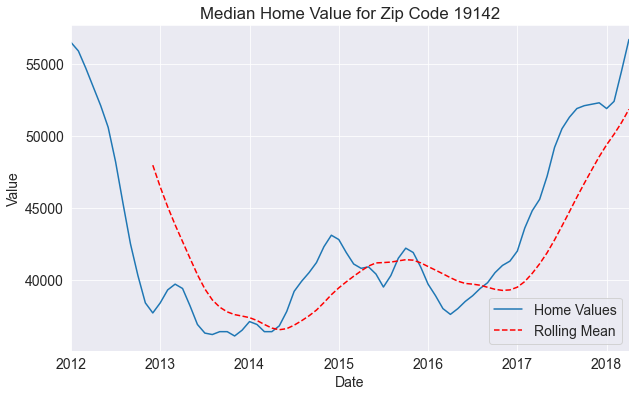

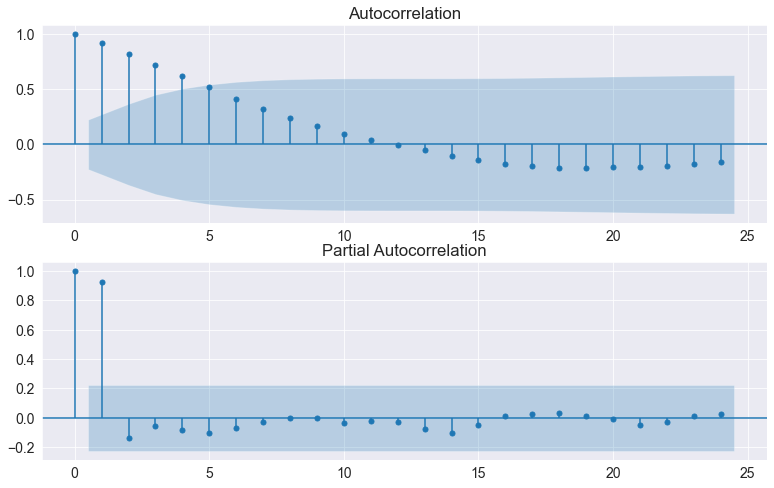

<Figure size 720x432 with 0 Axes>

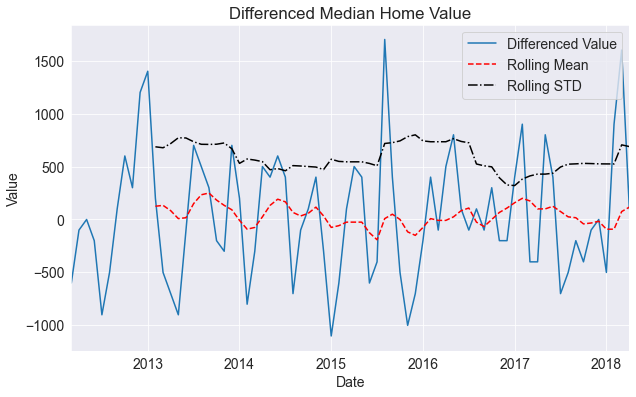

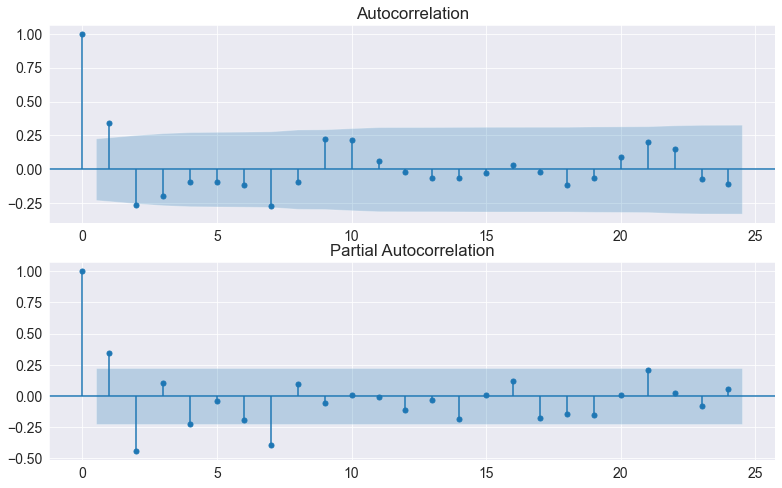

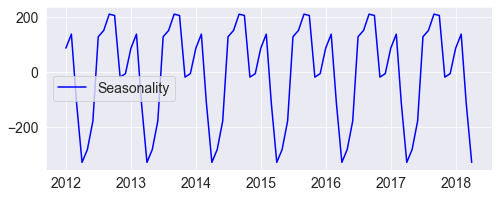

                               SARIMAX Results                                
Dep. Variable:                  value   No. Observations:                   58
Model:                 ARIMA(0, 2, 1)   Log Likelihood                -434.493
Date:                Tue, 24 Nov 2020   AIC                            872.985
Time:                        13:45:56   BIC                            877.036
Sample:                    01-01-2012   HQIC                           874.556
                         - 10-01-2016                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1          0.1084      0.047      2.328      0.020       0.017       0.200
sigma2      2.859e+05   4.42e+04      6.468      0.000    1.99e+05    3.73e+05
Ljung-Box (L1) (Q):                   6.12   Jarque-

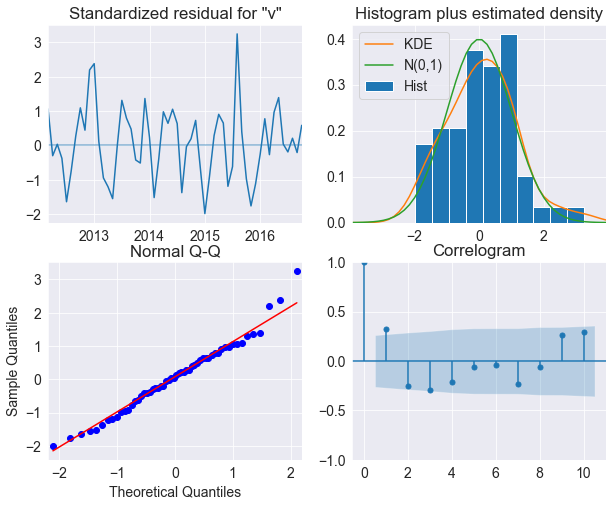

ARIMA model RMSE on train data: 585.78256


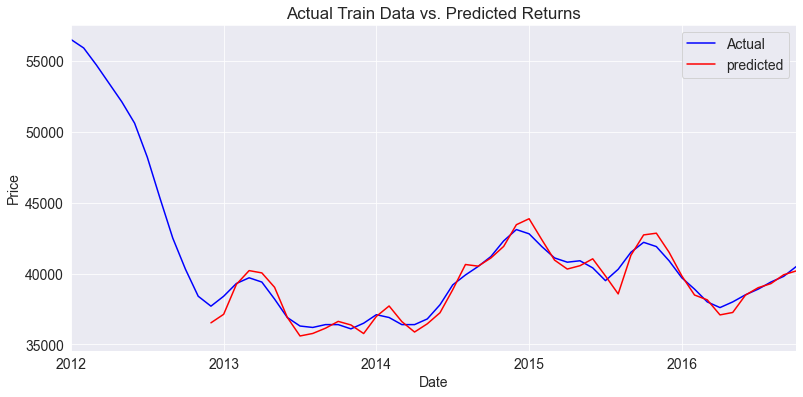

ARIMA model RMSE on test data: 5599.65177


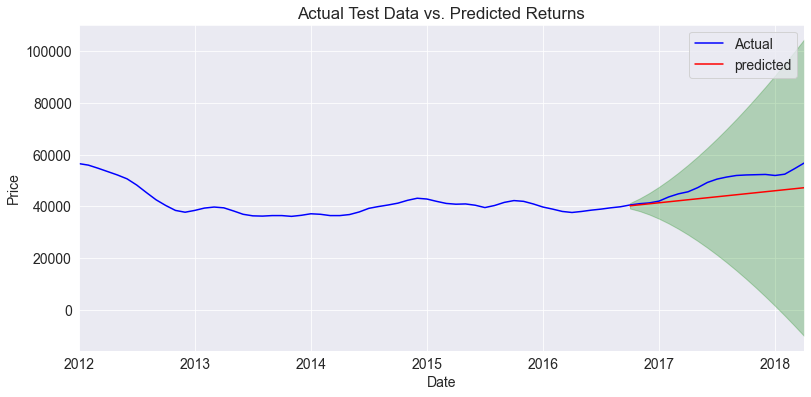

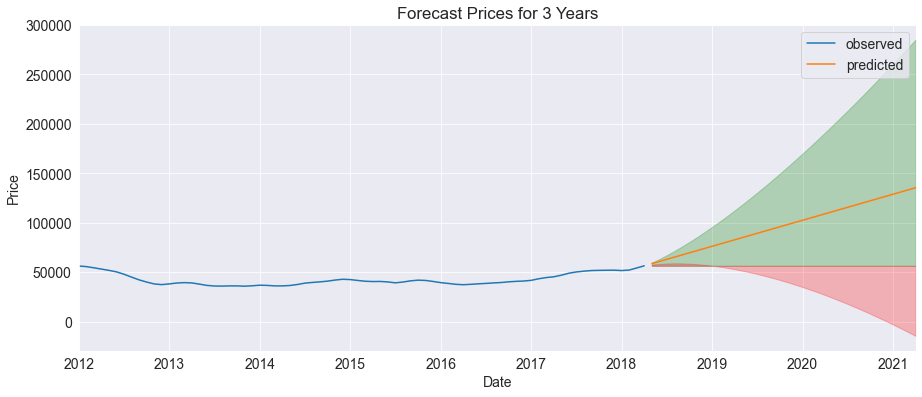

Returns after 1, 2, 3 years: 46.0%, 93.0%, 139.0%
Risk after 1, 2, 3 years: 6.0%, 18.0%, 24.0%


In [27]:
ts_19142 = ts_processor(24)

Zipcode 19142 has the highest ROI, but how does it hold up statistically? Like zipcode 19111, zipcode 19142 has high autocorrelation so we used the differenced series (d=2) for modeling. Looking at the ACF and PACF of the differenced series, I would have estimated our pdq as somewhere around (1, 2, 2), and the order (0, 2, 1) supplied by our helper function is pretty close. The seasonality plot shows little to no seasonality, so we do not need to change to a SARIMA model. When checking the model schematics, the Q-Q plot and histogram show that our residuals are fairly normally distributed, and the residuals look stationary. The Jarque-Bera test shows that our data is not normally distributed, but the the Ljung-Box test shows a lack of autocorrelation in the residuals. Over all, it seems like a decent, but not excellent fit. When looking at our test data and error, it seems like our model does a fairly good job of following the shape of the data.  The test error is within my comfort zone, and it seems like a solid model.  

Lets play with the model parameters and see if we can improve it at all. 

                               SARIMAX Results                                
Dep. Variable:                  value   No. Observations:                   58
Model:                 ARIMA(1, 2, 2)   Log Likelihood                -433.781
Date:                Tue, 24 Nov 2020   AIC                            875.563
Time:                        13:46:00   BIC                            883.664
Sample:                    01-01-2012   HQIC                           878.704
                         - 10-01-2016                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9232      0.104      8.885      0.000       0.720       1.127
ma.L1         -0.8318      0.109     -7.645      0.000      -1.045      -0.619
ma.L2         -0.1178      0.053     -2.212      0.0

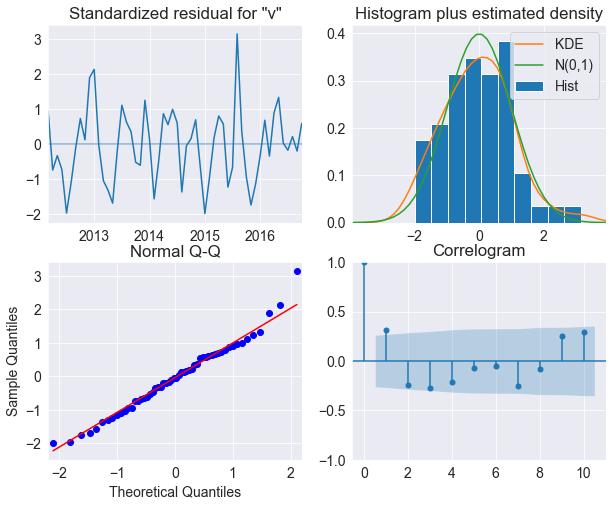

In [28]:
order = (1, 2, 2)
train, test, model = model_and_fit(ts_19142, order=order)

ARIMA model RMSE on train data: 569.04449


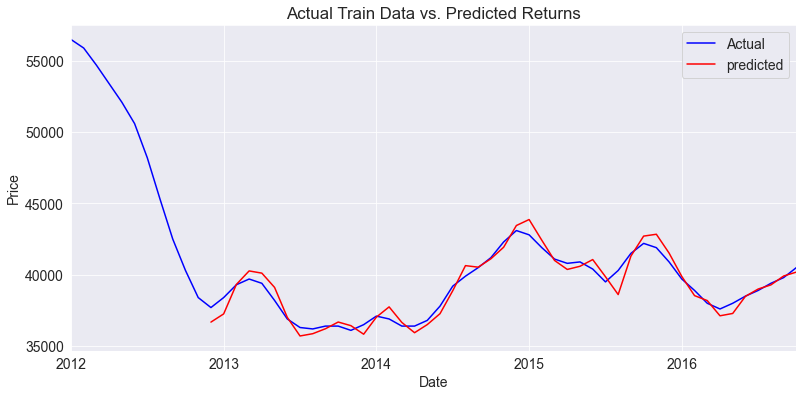

In [29]:
train_error(train, model)

ARIMA model RMSE on test data: 5548.71859


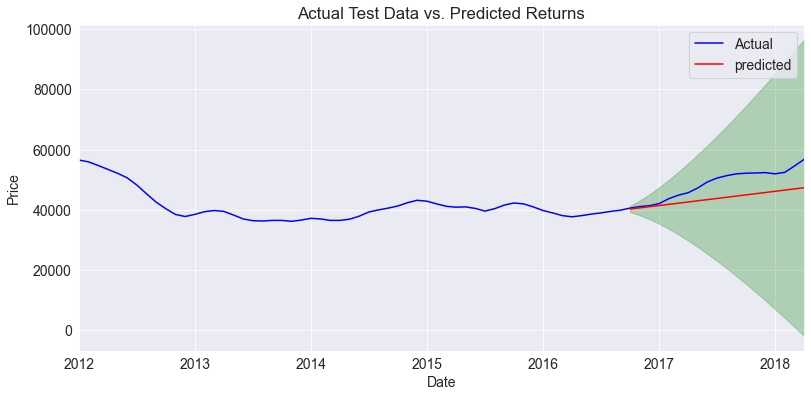

In [30]:
rmse = test_error(ts_19142, test, model)

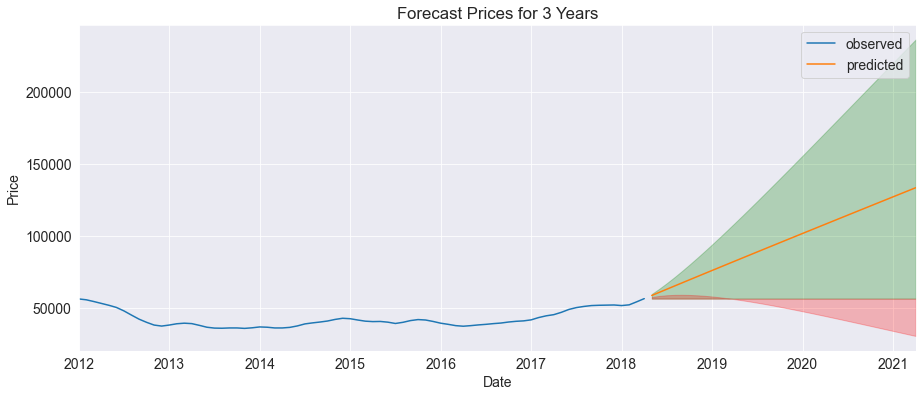

Return on investment after 1, 2, 3 years: 46.0%, 91.0%, 135.0%
Risk on investment after 1, 2, 3 years: 1.0%, 9.0%, 13.0%


In [31]:
roi1, roi2, roi3, risk1, risk2, risk3 = forecast(ts_19142, order=order)
print('Return on investment after 1, 2, 3 years: {}%, {}%, {}%'.format(round(roi1, 2)*100, 
                                                                       round(roi2, 2)*100, 
                                                                       round(roi3, 2)*100))
print('Risk on investment after 1, 2, 3 years: {}%, {}%, {}%'.format(round(risk1, 2)*100, 
                                                                     round(risk2, 2)*100, 
                                                                     round(risk3, 2)*100))

After tinkering with the pdq order, the best model seems to use (0, 2, 1) as supplied by our helper function.  The model using order (1, 2, 2), shown above, is close with a similar test error score but worse residuals. Both models are sufficient in this case, but I would lean toward using (0, 2, 1). Let's assess the risk in this zipcode. The investment cost is very low compared to the median prices in Philadelphia. This gives us some stability in our investment as we have significantly less to lose. That combined with the high ROI's make this a good place to look. Our testing error is a little higher than I would like considering the low price of homes, but is still pretty good and if anything our model is conservative. Our risk estimates are not too bad, though they do get a bit high at the three year mark. Ultimately I would recommend investing here as it shows a very high potential return with mild risk.

Let's look at the generated model for the next zipcode.

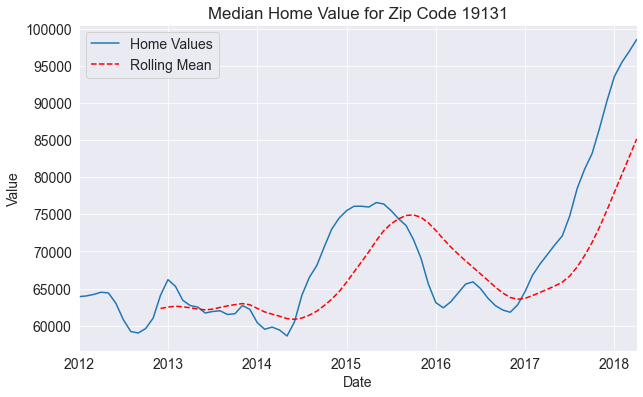

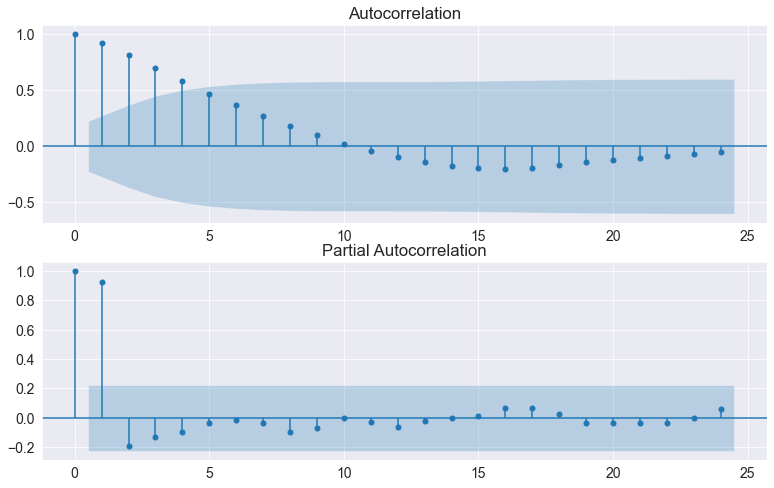

<Figure size 720x432 with 0 Axes>

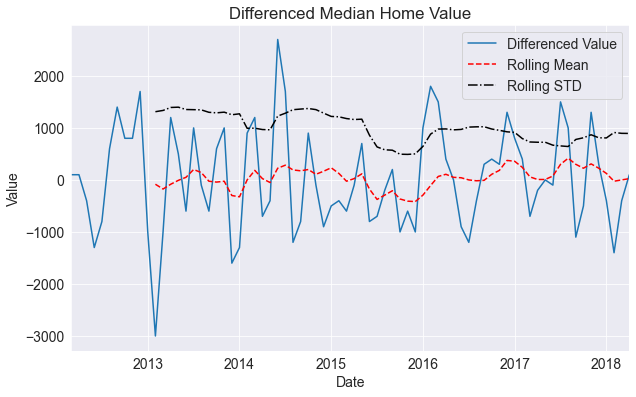

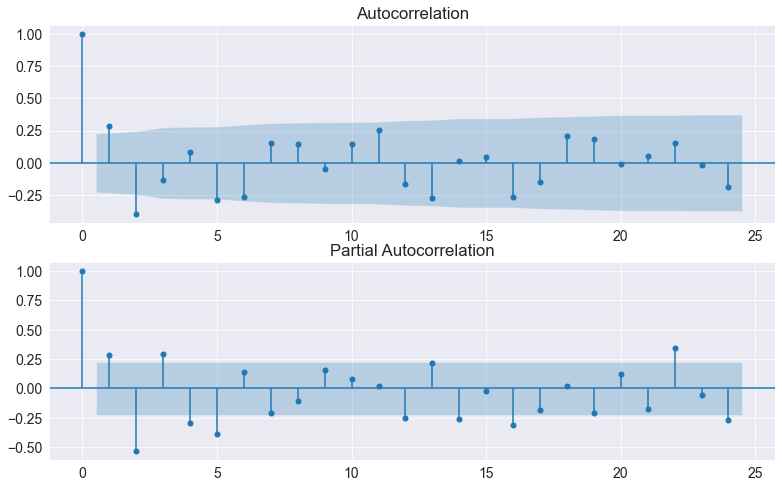

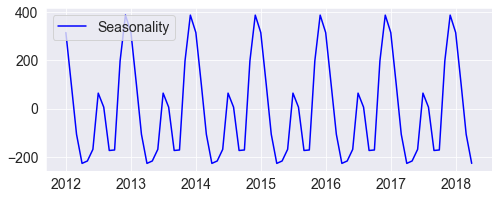

                               SARIMAX Results                                
Dep. Variable:                  value   No. Observations:                   58
Model:                 ARIMA(2, 2, 2)   Log Likelihood                -459.489
Date:                Tue, 24 Nov 2020   AIC                            928.979
Time:                        13:46:07   BIC                            939.106
Sample:                    01-01-2012   HQIC                           932.905
                         - 10-01-2016                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.3314      0.033    -10.180      0.000      -0.395      -0.268
ar.L2         -0.9503      0.023    -41.594      0.000      -0.995      -0.906
ma.L1          0.3880      0.044      8.841      0.0

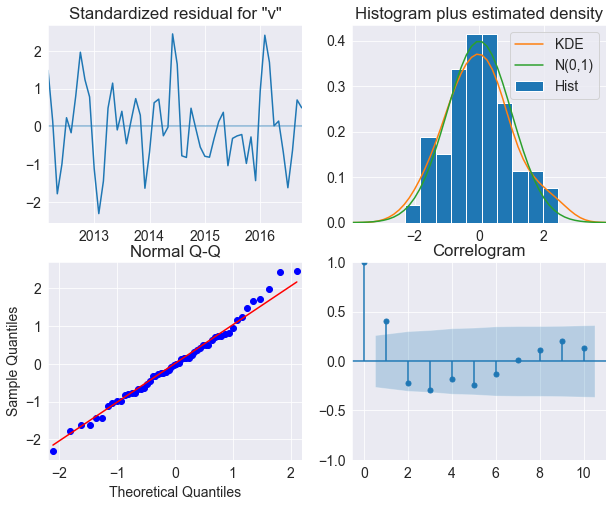

ARIMA model RMSE on train data: 856.32388


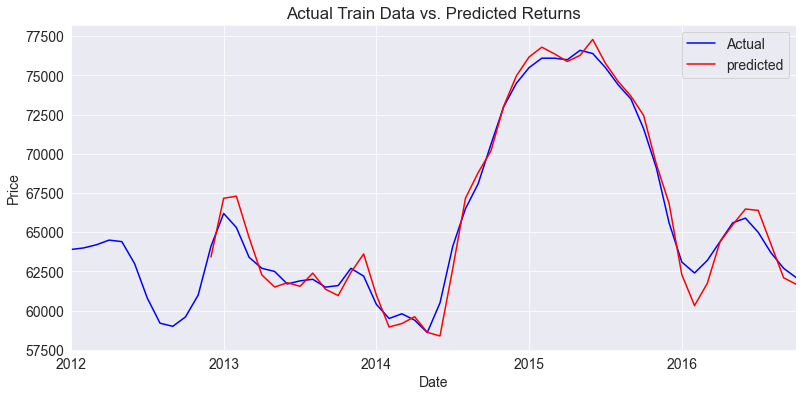

ARIMA model RMSE on test data: 29394.11776


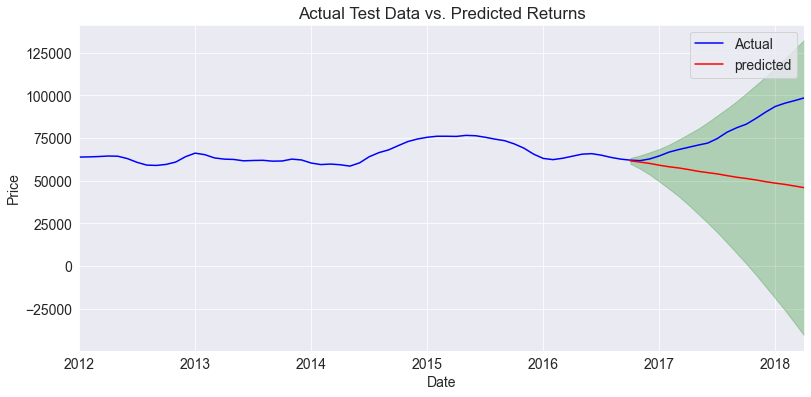

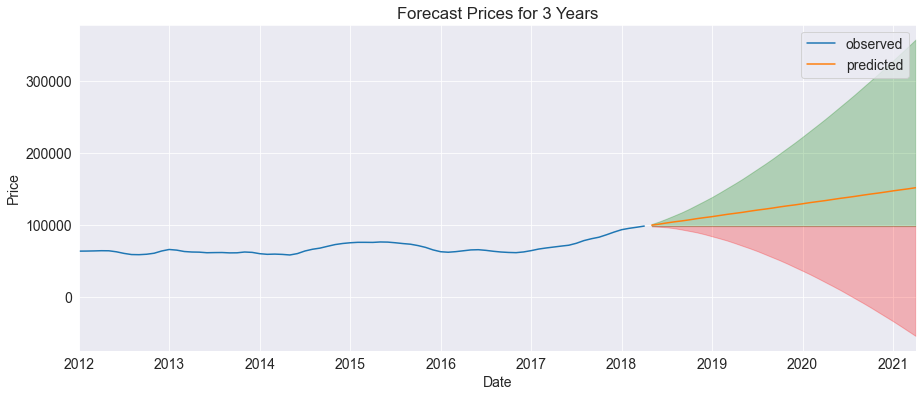

Returns after 1, 2, 3 years: 18.0%, 36.0%, 54.0%
Risk after 1, 2, 3 years: 28.999999999999996%, 34.0%, 37.0%


In [32]:
ts_19131 = ts_processor(5)

Next up is zipcode 19131. Again we are using the differenced model to provide stationarity and to solve some of the autocorrelation.  Looking at the ACF and PACF I would estimate our best order to be (2, 2, 2) which is the same as the one recommended by our helper function. Again, we have no seasonality so we will stick with the ARIMA model. The model schematics are very similar to the first model, showing the residuals have no evidence of autocorrelation but are not normally distributed. Our testing data performs much worse here as it doesn't reflect the shape of the test data.  There is a significant upturn in home prices that occurs about the same time our predictions start. As a consequence, our model follows the shape of the data before that point and heads in a different direction than the data. I imagine our testing error would decrease considerably if we trained our testing window, but we would run into the same issues with other zip codes. The observed values still fall within our confidence interval, but the model does not perform well enough to recommend investing in zipcode 19131. The risk estimates are also higher than I am comfortable with. The somewhat low price of homes in this zipcode slightly lowers the risk, since it is a smaller investment here than it would be in other areas of the city, but I'm still not confident with it.

I'm going to tinker with the parameters again and see if we can improve the model.

                               SARIMAX Results                                
Dep. Variable:                  value   No. Observations:                   58
Model:                 ARIMA(1, 2, 1)   Log Likelihood                -467.999
Date:                Tue, 24 Nov 2020   AIC                            941.998
Time:                        13:46:10   BIC                            948.074
Sample:                    01-01-2012   HQIC                           944.354
                         - 10-01-2016                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.3074      2.877     -0.107      0.915      -5.946       5.331
ma.L1          0.3284      2.853      0.115      0.908      -5.264       5.920
sigma2      1.053e+06   1.97e+05      5.345      0.0

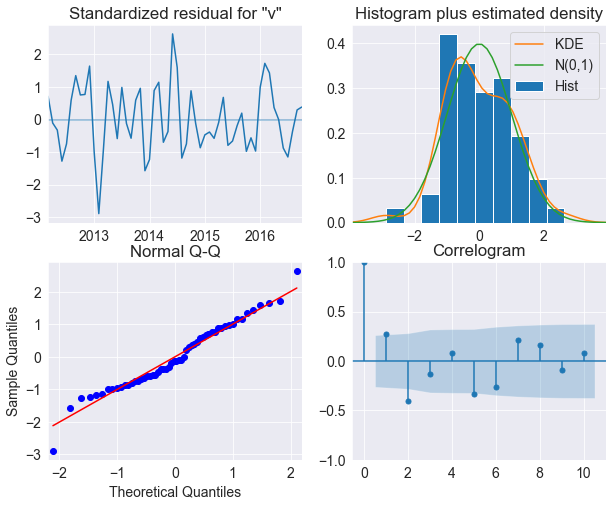

In [33]:
order= (1,2,1)
train, test, model = model_and_fit(ts_19131, order)

ARIMA model RMSE on train data: 1062.13263


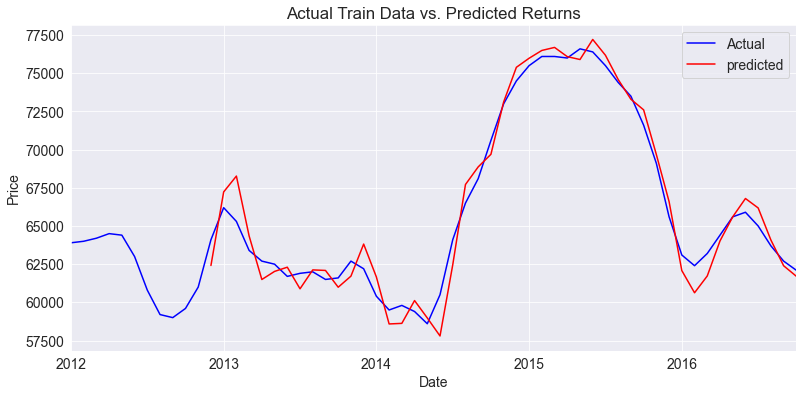

In [34]:
train_error(train, model)

ARIMA model RMSE on test data: 30709.81219


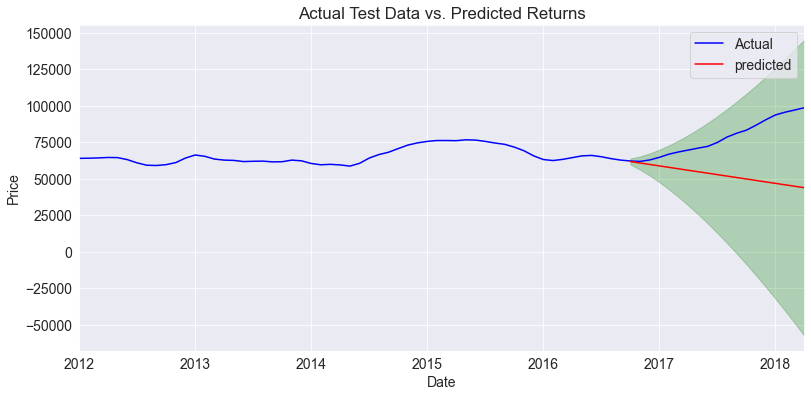

In [35]:
rmse = test_error(ts_19131, test, model)

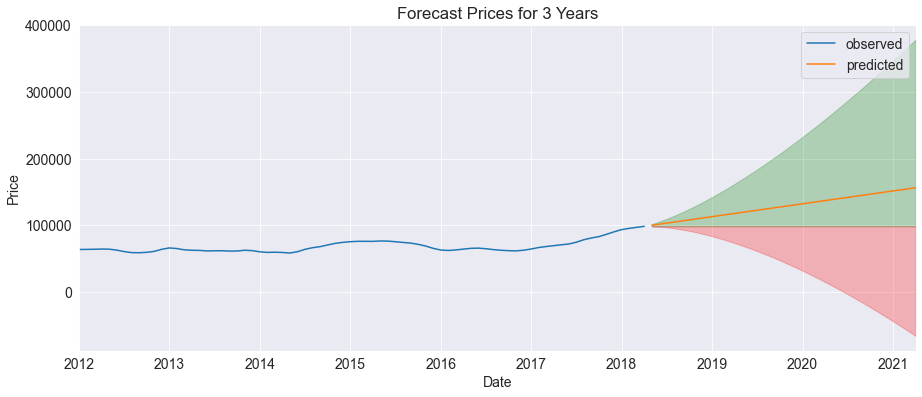

Return on investment after 1, 2, 3 years: 20.0%, 39.0%, 59.0%
Risk on investment after 1, 2, 3 years: 28.000000000000004%, 34.0%, 37.0%


In [36]:
roi1, roi2, roi3, risk1, risk2, risk3 = forecast(ts_19131, order=order)
print('Return on investment after 1, 2, 3 years: {}%, {}%, {}%'.format(round(roi1, 2)*100, 
                                                                       round(roi2, 2)*100, 
                                                                       round(roi3, 2)*100))
print('Risk on investment after 1, 2, 3 years: {}%, {}%, {}%'.format(round(risk1, 2)*100, 
                                                                     round(risk2, 2)*100, 
                                                                     round(risk3, 2)*100))

After playing with the model, I couldn't make a better one than the original supplied by our generator. The closest used order (1, 2, 1), shown above, but all it accomplished was to underfit the model a bit (as there is some heavy evidence of overfitting). I like the original model better though as it has better residuals and shows a better fit. 

As for investing in this zipcode, it seems very risky. We are unable to fully trust the model due to our test data.  This could likely be fixed if we changed the distribution of our train/test data, but by the parameters that we set for this project, I would not recommend using these predictions. Furthermore, the risk estimates are very high. I would advise skipping investing here. 

Next up is zipcode 19124.

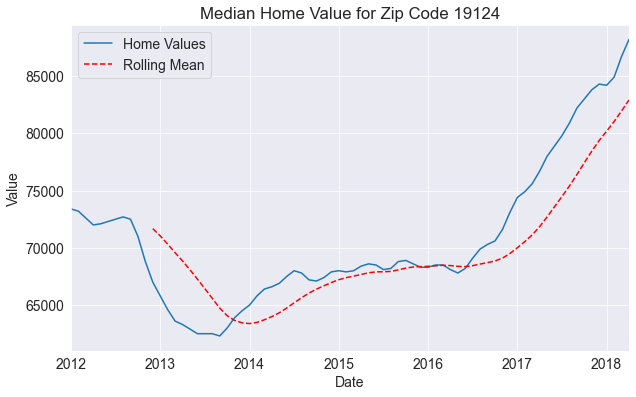

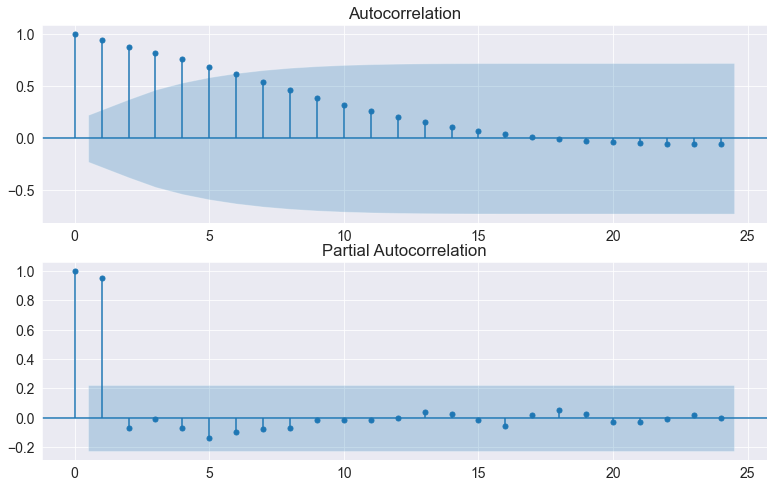

<Figure size 720x432 with 0 Axes>

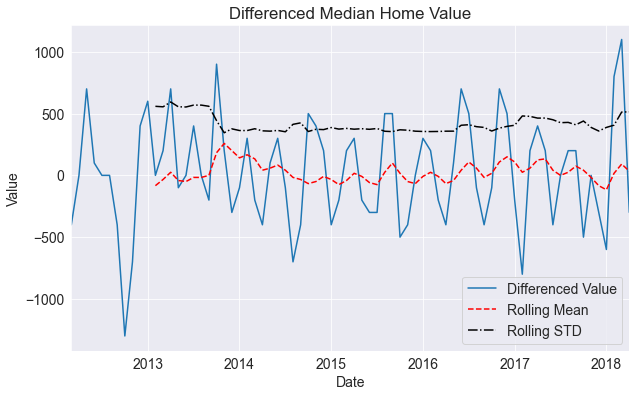

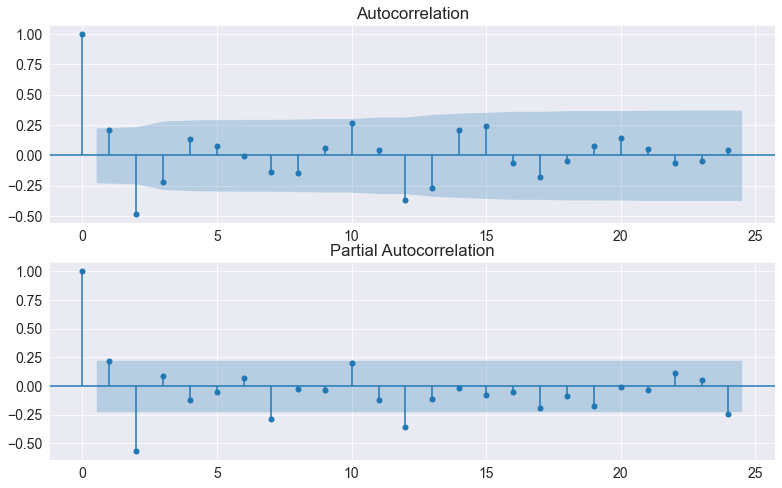

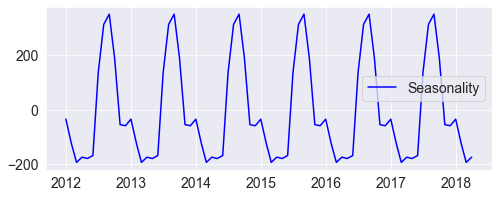

                               SARIMAX Results                                
Dep. Variable:                  value   No. Observations:                   58
Model:                 ARIMA(3, 2, 0)   Log Likelihood                -411.888
Date:                Tue, 24 Nov 2020   AIC                            831.777
Time:                        13:46:16   BIC                            839.878
Sample:                    01-01-2012   HQIC                           834.918
                         - 10-01-2016                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0680      0.073      0.926      0.354      -0.076       0.212
ar.L2         -0.0566      0.043     -1.315      0.188      -0.141       0.028
ar.L3         -0.0982      0.106     -0.924      0.3

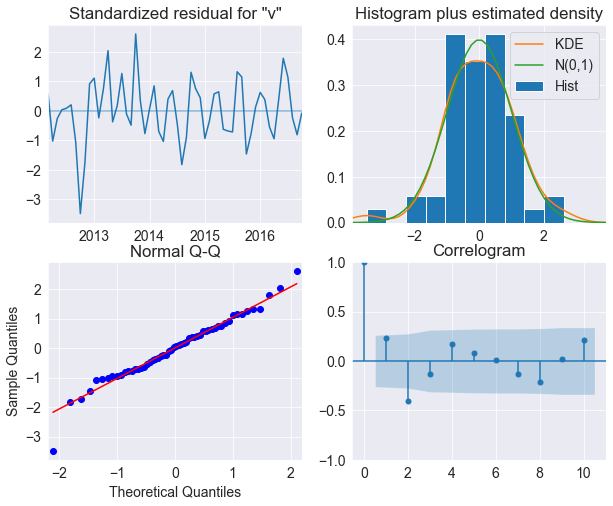

ARIMA model RMSE on train data: 345.90614


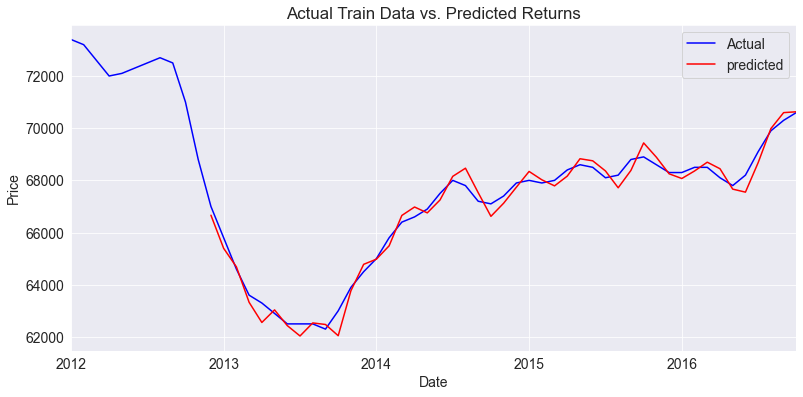

ARIMA model RMSE on test data: 6113.03462


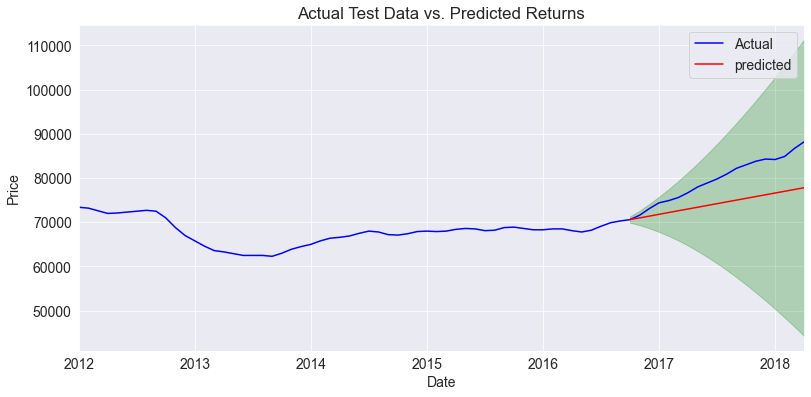

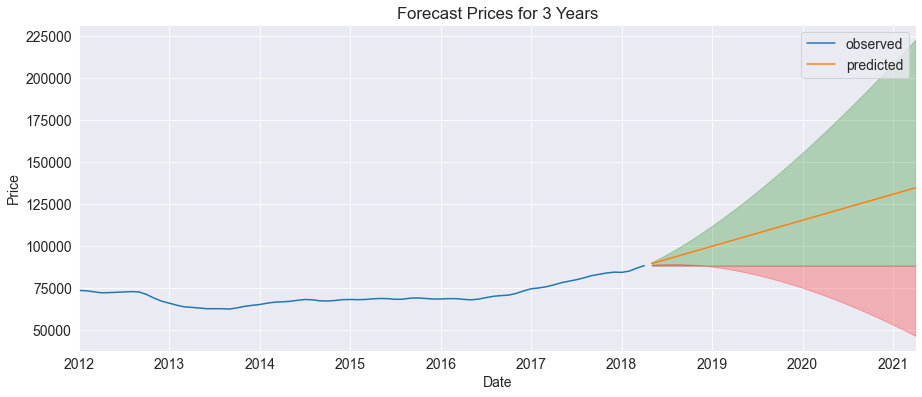

Returns after 1, 2, 3 years: 18.0%, 35.0%, 53.0%
Risk after 1, 2, 3 years: 7.000000000000001%, 18.0%, 24.0%


In [37]:
ts_19124 = ts_processor(1)

We are still using a differenced series here, and we are sticking with ARIMA due to the lack of seasonality. Our residuals look a little closer to normal here with a decent Q-Q plot but the Jarque-Bera test still shows that they are not entirely normal.  Still no evidence of autocorrelation in our residuals.  Our testing data looks really good here, matching the shape of the data pretty nicely. Our risk is fairly low here, at least for the first year. I am a little surprised with the AR term for this model as I would have estimated it to be lower.  Once again, I am going to play with the model and see if I can improve upon it.

                               SARIMAX Results                                
Dep. Variable:                  value   No. Observations:                   58
Model:                 ARIMA(2, 2, 0)   Log Likelihood                -414.361
Date:                Tue, 24 Nov 2020   AIC                            834.723
Time:                        13:46:20   BIC                            840.799
Sample:                    01-01-2012   HQIC                           837.078
                         - 10-01-2016                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0783      0.062      1.271      0.204      -0.042       0.199
ar.L2         -0.0566      0.039     -1.451      0.147      -0.133       0.020
sigma2      1.444e+05   2.33e+04      6.189      0.0

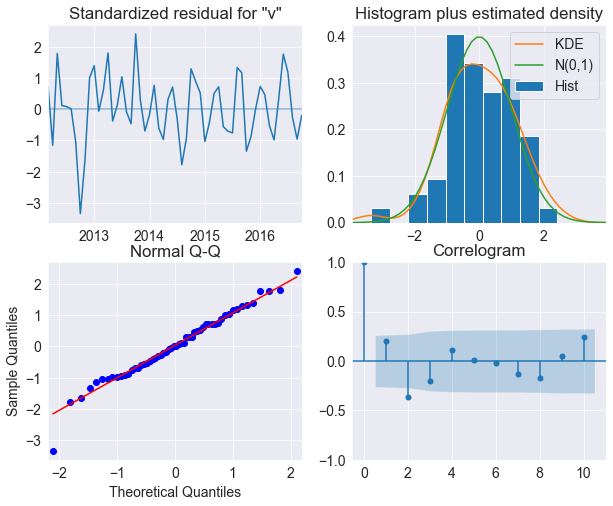

In [38]:
order=(2, 2, 0)
train, test, model = model_and_fit(ts_19124, order)

ARIMA model RMSE on train data: 352.77925


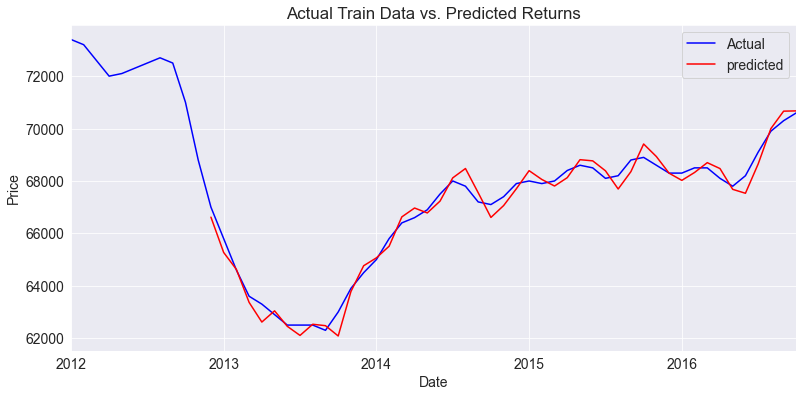

In [39]:
train_error(train, model)

ARIMA model RMSE on test data: 6090.35929


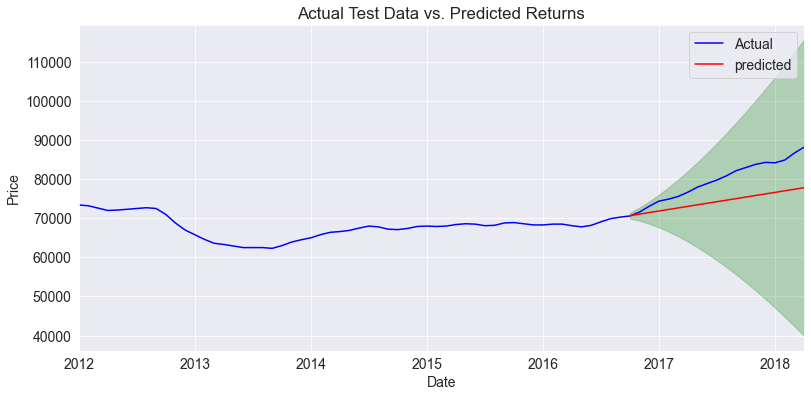

In [40]:
rmse = test_error(ts_19124, test, model)

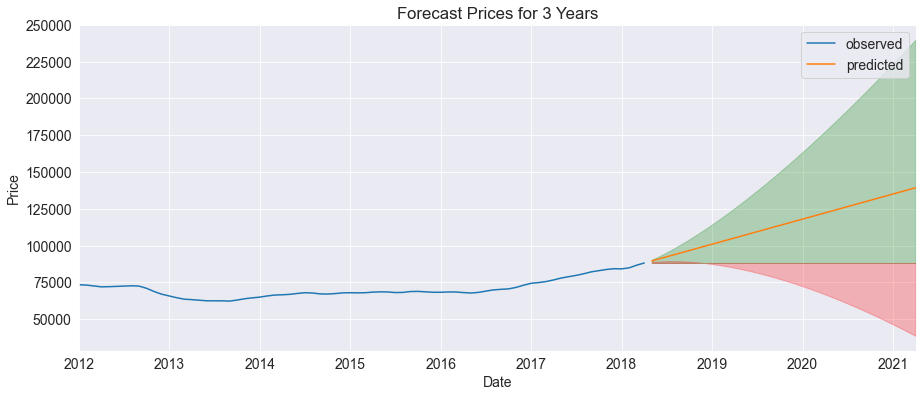

Return on investment after 1, 2, 3 years: 19.0%, 39.0%, 57.99999999999999%
Risk on investment after 1, 2, 3 years: 8.0%, 19.0%, 25.0%


In [41]:
roi1, roi2, roi3, risk1, risk2, risk3 = forecast(ts_19124, order=order)
print('Return on investment after 1, 2, 3 years: {}%, {}%, {}%'.format(round(roi1, 2)*100, 
                                                                       round(roi2, 2)*100, 
                                                                       round(roi3, 2)*100))
print('Risk on investment after 1, 2, 3 years: {}%, {}%, {}%'.format(round(risk1, 2)*100, 
                                                                     round(risk2, 2)*100, 
                                                                     round(risk3, 2)*100))

Again I wasn't able to improve on the model supplied by the helper function. You can trade off test and train error for a slight worsening of residuals, but the original model still fits the best.

I would be very confident in investing in this zipcode even though it doesn't offer quite as high of a return. The cost to invest is relatively low and there are some large gains for mild risk. This zipcode especially suits a short term investment as the risk is minimal until around 1 year passes. There is potential for a quick turn around to generate some capital, especially since the cost in this zipcode is also lower than the average home in Philadelphia. It seems's like some of the best places to invest in Philly are ones where the homes have been worth less historically.

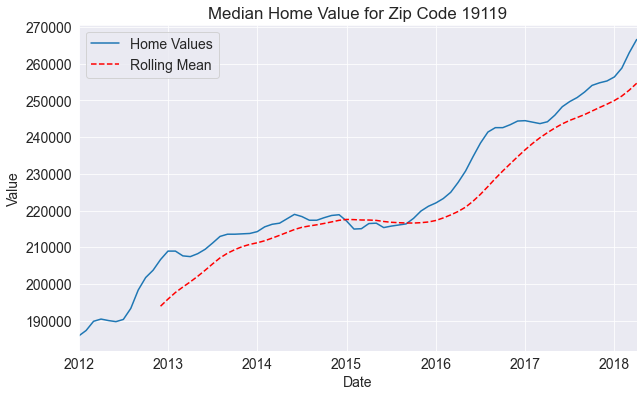

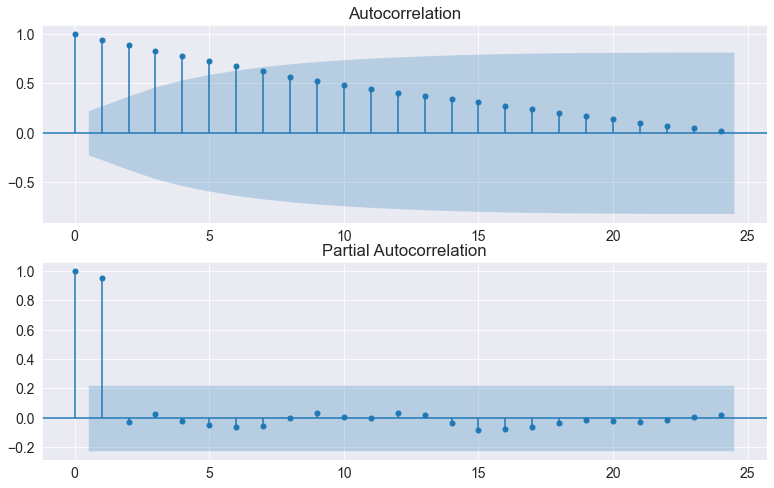

<Figure size 720x432 with 0 Axes>

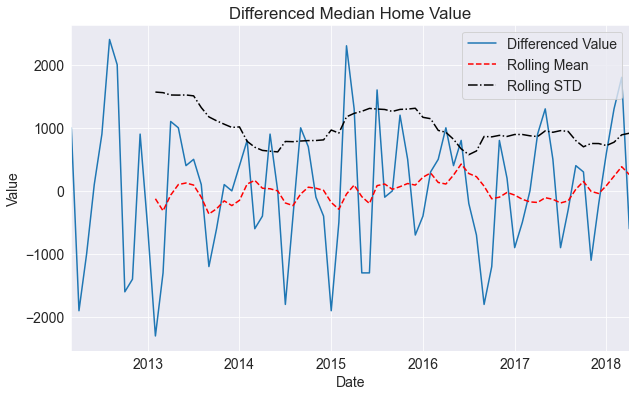

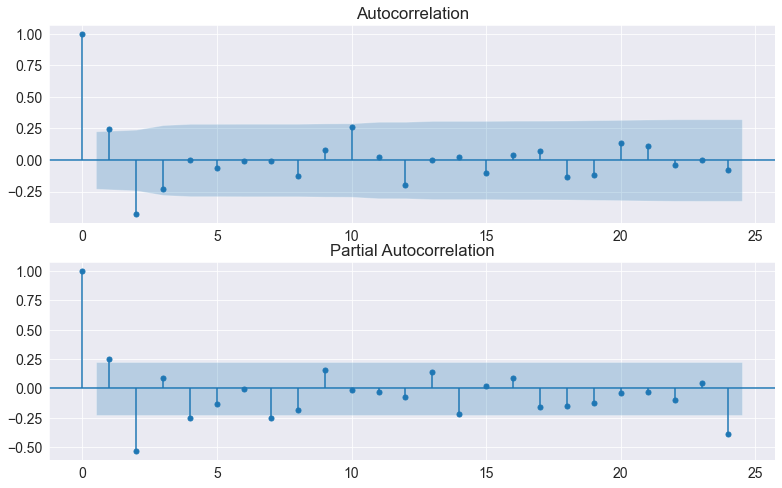

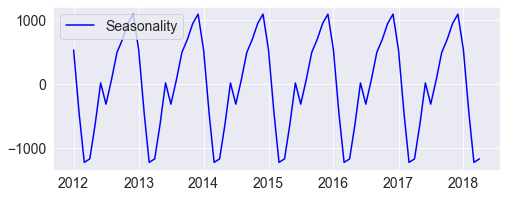

                               SARIMAX Results                                
Dep. Variable:                  value   No. Observations:                   58
Model:                 ARIMA(4, 2, 4)   Log Likelihood                -476.611
Date:                Tue, 24 Nov 2020   AIC                            971.222
Time:                        13:46:27   BIC                            989.450
Sample:                    01-01-2012   HQIC                           978.289
                         - 10-01-2016                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.4265      0.145      2.951      0.003       0.143       0.710
ar.L2         -0.2349      0.175     -1.345      0.179      -0.577       0.107
ar.L3          0.2621      0.136      1.925      0.0

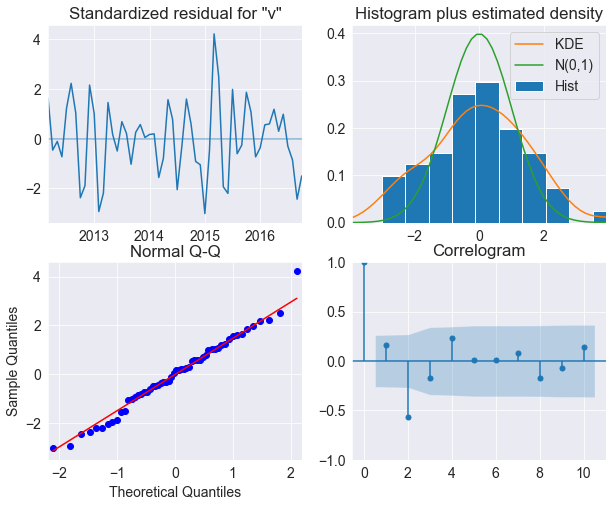

ARIMA model RMSE on train data: 977.84020


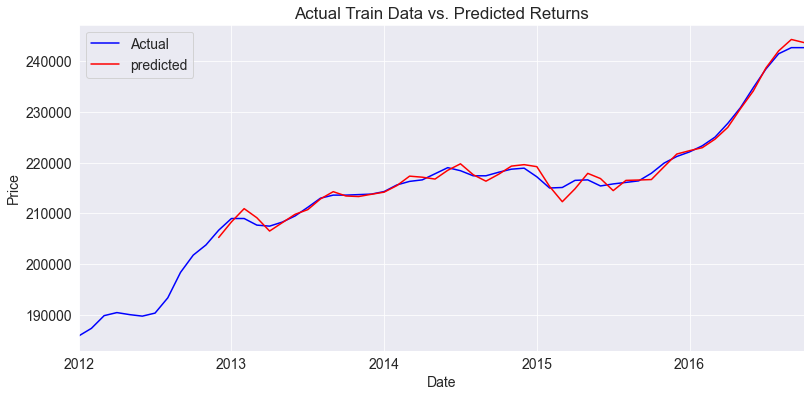

ARIMA model RMSE on test data: 3826.63717


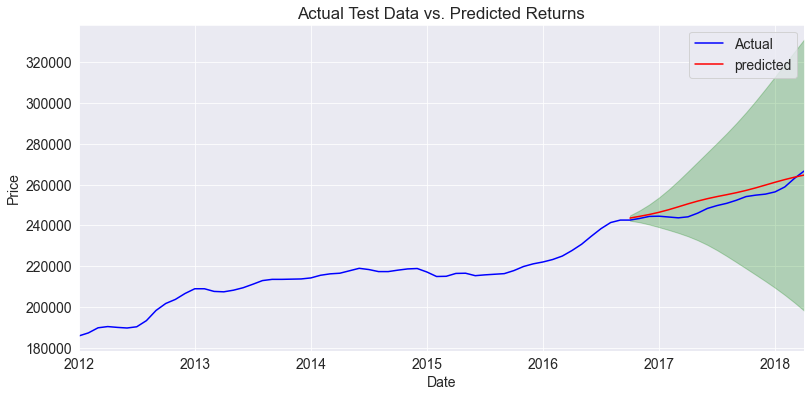

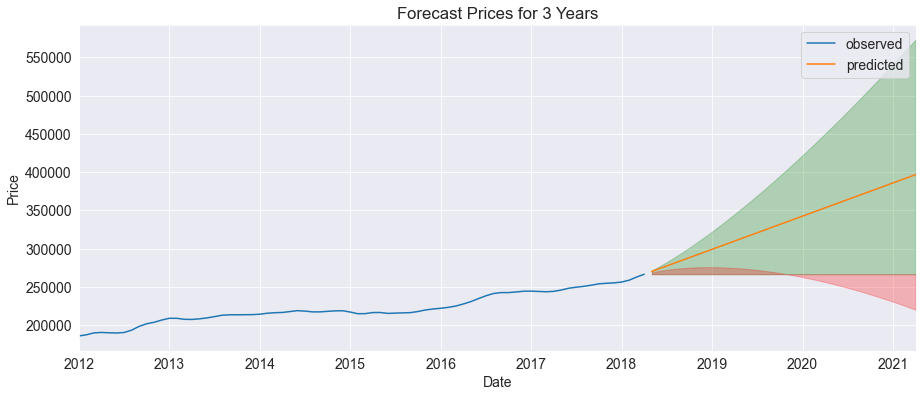

Returns after 1, 2, 3 years: 16.0%, 33.0%, 49.0%
Risk after 1, 2, 3 years: -12.0%, 5.0%, 13.0%


In [42]:
ts_19119 = ts_processor(22)

The seasonality in zip code 19119 is about twice as strong as the other zipcodes, but the house prices are also about twice as expensive. We will still stick with the ARIMA model, but there may be a case for a SARIMA model here. 
The ARIMA model does have an excellent test score and the shape of the predictions match the shape of the data nicely. Further, the risk estimates are very low. In regards to the model schematics, our residuals are decidely not normally distributed as seen in the histogram, though as usual there is no sign of autocorrelation in them.  The model seems well-fit and I would recommend investing here.  The investment might be a little more commital than in other zip codes since the price of homes is higher, but there is less inherent risk. I am going to attempt to tune the model to see if we can improve our results. 

                               SARIMAX Results                                
Dep. Variable:                  value   No. Observations:                   58
Model:                 ARIMA(2, 2, 2)   Log Likelihood                -470.700
Date:                Tue, 24 Nov 2020   AIC                            951.400
Time:                        13:46:31   BIC                            961.527
Sample:                    01-01-2012   HQIC                           955.326
                         - 10-01-2016                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.4775      0.031     48.323      0.000       1.418       1.537
ar.L2         -0.9468      0.026    -35.848      0.000      -0.999      -0.895
ma.L1         -1.4576      0.032    -45.171      0.0

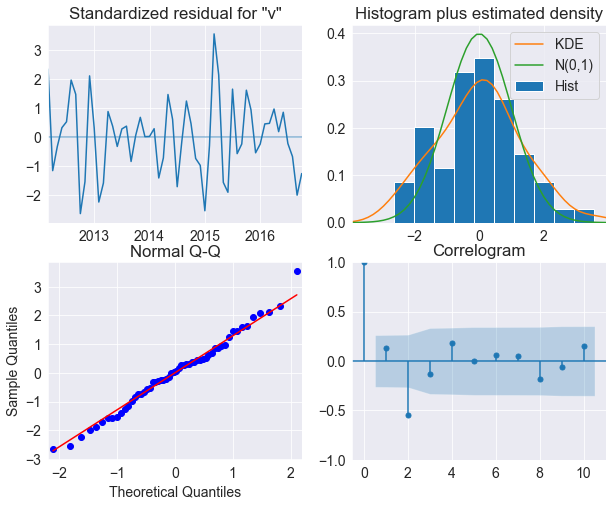

In [43]:
order=(2, 2, 2)
train, test, model = model_and_fit(ts_19119, order)

ARIMA model RMSE on train data: 951.60462


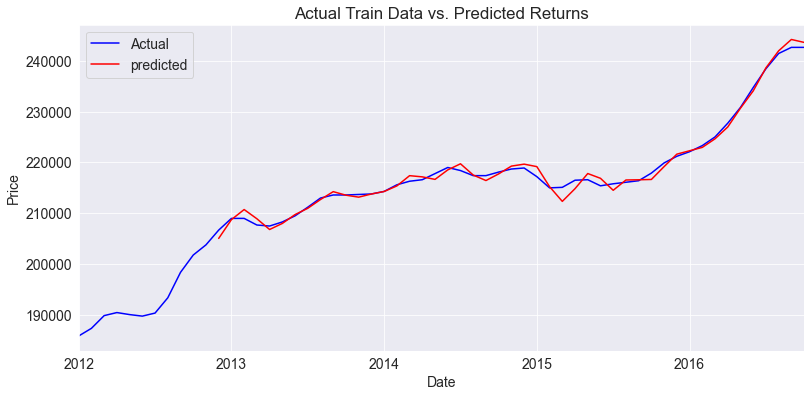

In [44]:
train_error(train, model)

ARIMA model RMSE on test data: 4413.51589


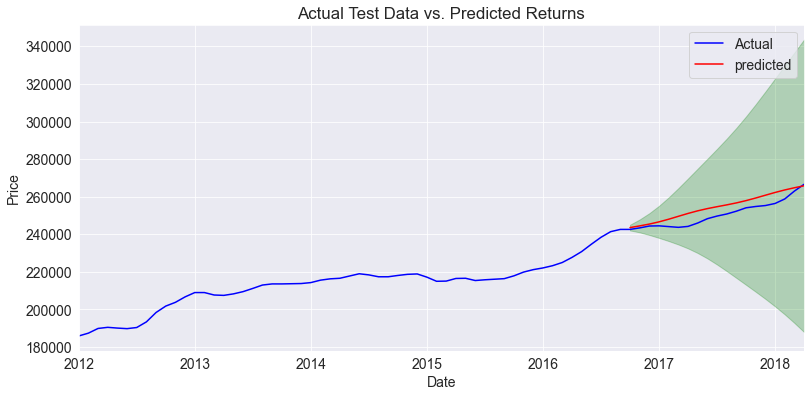

In [45]:
rmse = test_error(ts_19119, test, model)

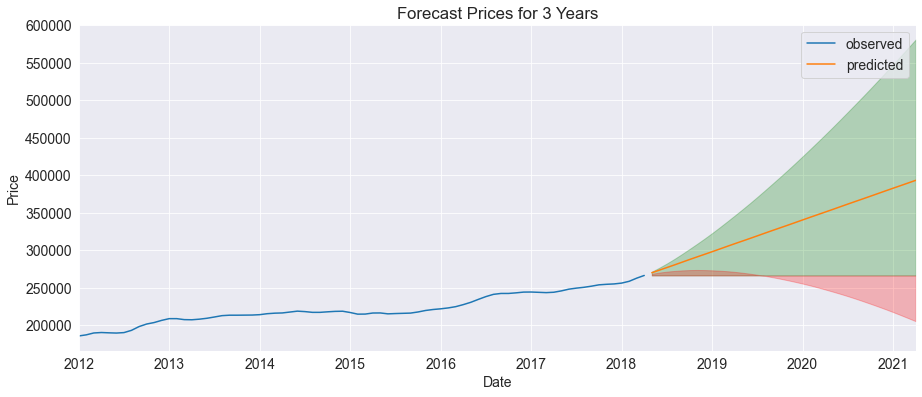

Return on investment after 1, 2, 3 years: 16.0%, 32.0%, 48.0%
Risk on investment after 1, 2, 3 years: -6.0%, 9.0%, 16.0%


In [46]:
roi1, roi2, roi3, risk1, risk2, risk3 = forecast(ts_19119, order=order)
print('Return on investment after 1, 2, 3 years: {}%, {}%, {}%'.format(round(roi1, 2)*100, 
                                                                       round(roi2, 2)*100, 
                                                                       round(roi3, 2)*100))
print('Risk on investment after 1, 2, 3 years: {}%, {}%, {}%'.format(round(risk1, 2)*100, 
                                                                     round(risk2, 2)*100, 
                                                                     round(risk3, 2)*100))

I actually like this model slightly better. Our projected returns get slightly smaller, but our test error and residuals get a bit better. We retain all of the strengths of the original model, but tune it ever so slightly. Other than the relatively high investment cost, this is a prime zip code to invest in.

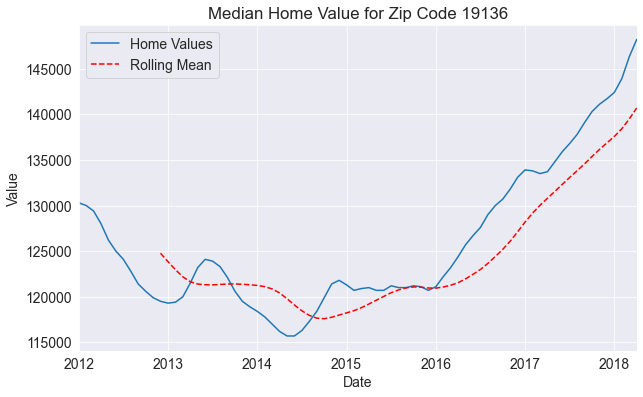

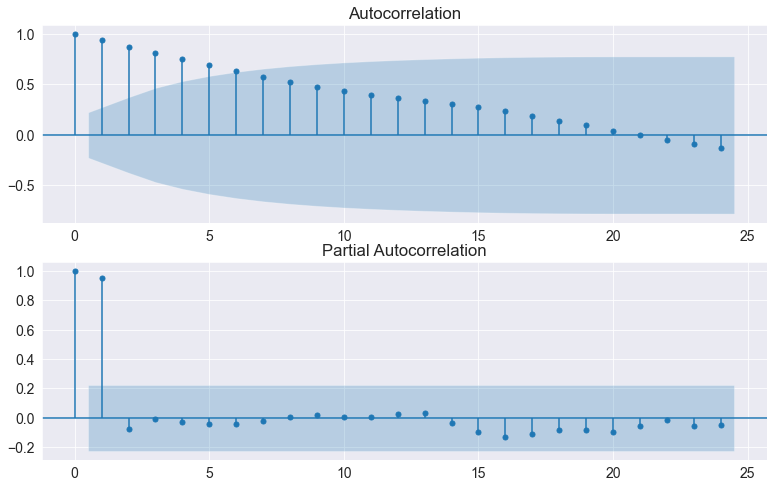

<Figure size 720x432 with 0 Axes>

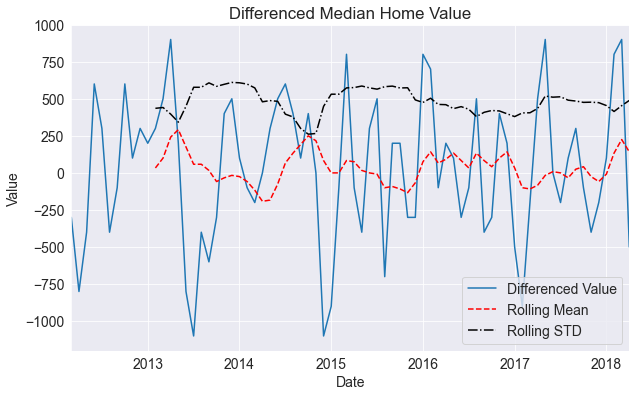

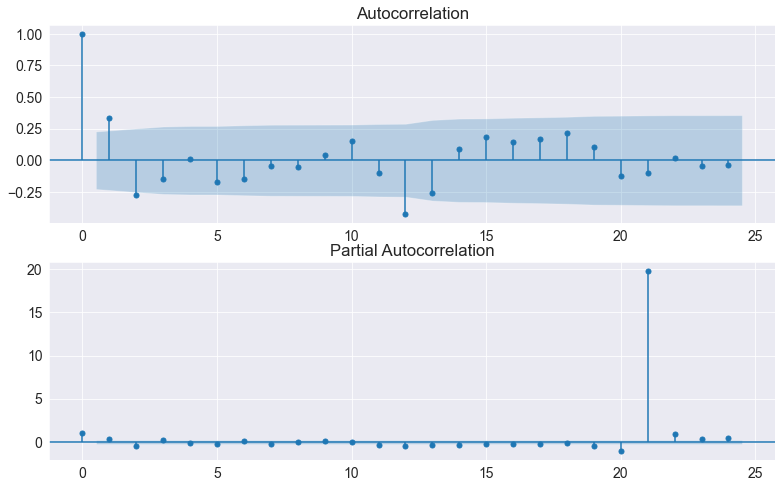

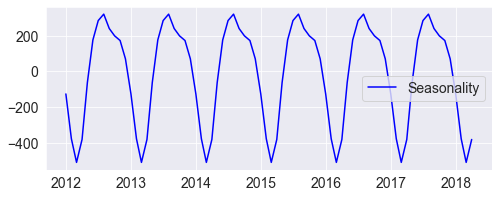

                               SARIMAX Results                                
Dep. Variable:                  value   No. Observations:                   58
Model:                 ARIMA(4, 2, 4)   Log Likelihood                -417.988
Date:                Tue, 24 Nov 2020   AIC                            853.975
Time:                        13:46:38   BIC                            872.203
Sample:                    01-01-2012   HQIC                           861.042
                         - 10-01-2016                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.1207      0.086     13.036      0.000       0.952       1.289
ar.L2         -0.6631      0.103     -6.452      0.000      -0.865      -0.462
ar.L3          1.1718      0.098     11.976      0.0

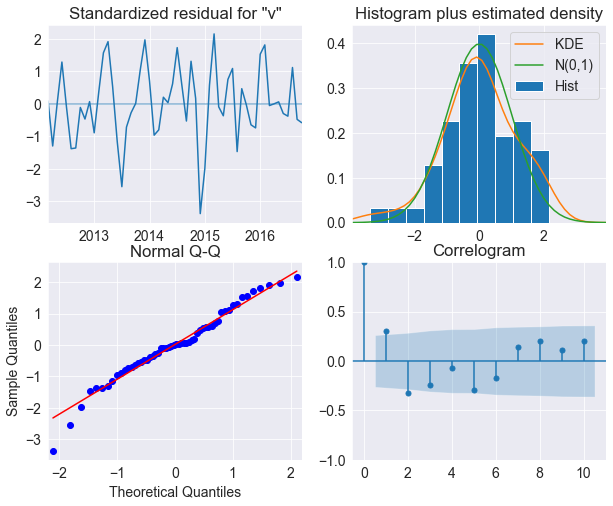

ARIMA model RMSE on train data: 430.21976


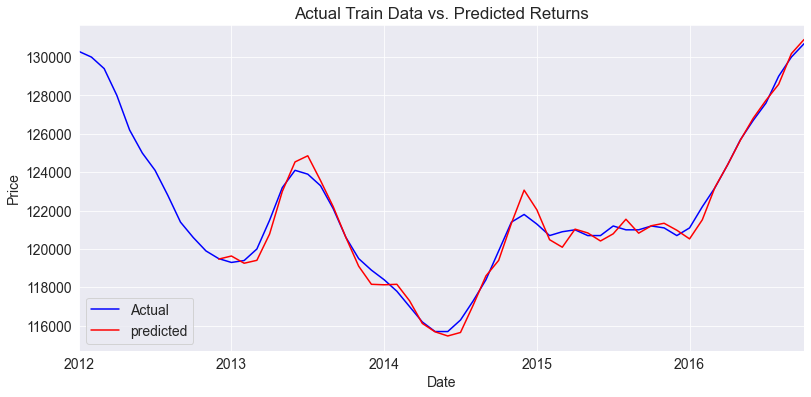

ARIMA model RMSE on test data: 1413.65236


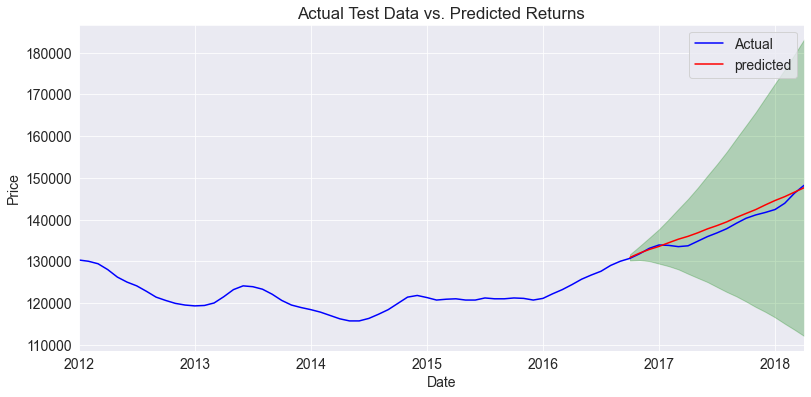

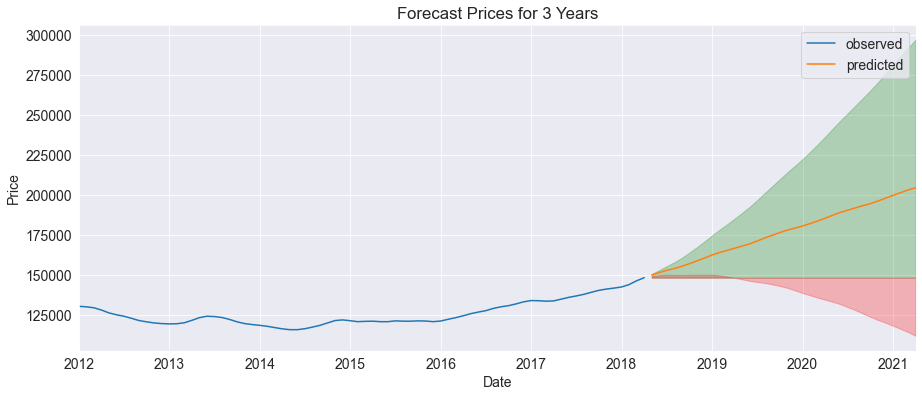

Returns after 1, 2, 3 years: 12.0%, 25.0%, 38.0%
Risk after 1, 2, 3 years: 0.0%, 14.000000000000002%, 20.0%


In [47]:
ts_19136 = ts_processor(17)

This zipcode is fairly similar to the last. The main difference is in the price of homes. They are overall much cheaper in this zip code, meaning we again have a lower investment cost. Just like with the rest of the high ROI zip codes, we can safely stick to ARIMA modeling because there is very low seasonality. Our residuals from the model are a little iffy, but we will see if we can tune them below. As far as risk, there is very low likelihood of taking a loss here, and our test error term is low meaing we can faith in those predictions. While the ROI is slightly lower here, there is less risk overall, so this strikes me as a safe investment for a solid, though not exeptional return. Again we will tinker with the parameters to try to get a better fit.

                               SARIMAX Results                                
Dep. Variable:                  value   No. Observations:                   58
Model:                 ARIMA(1, 2, 2)   Log Likelihood                -423.396
Date:                Tue, 24 Nov 2020   AIC                            854.791
Time:                        13:46:42   BIC                            862.893
Sample:                    01-01-2012   HQIC                           857.932
                         - 10-01-2016                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.1845      0.896      0.206      0.837      -1.572       1.941
ma.L1         -0.1558      0.899     -0.173      0.862      -1.918       1.607
ma.L2          0.0318      0.109      0.292      0.7

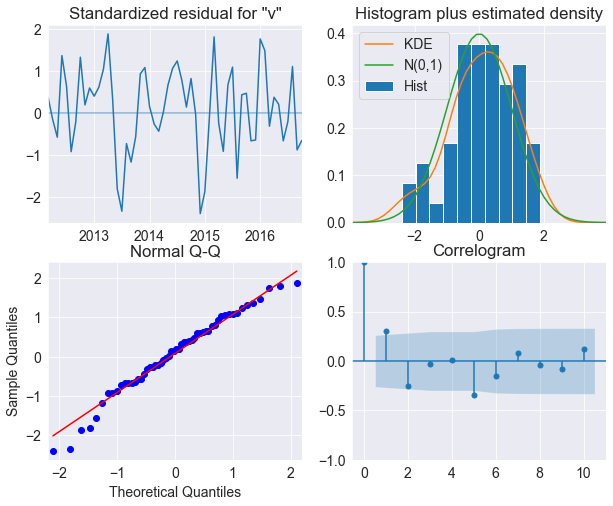

In [48]:
order=(1, 2, 2)
train, test, model = model_and_fit(ts_19136, order)

ARIMA model RMSE on train data: 482.01652


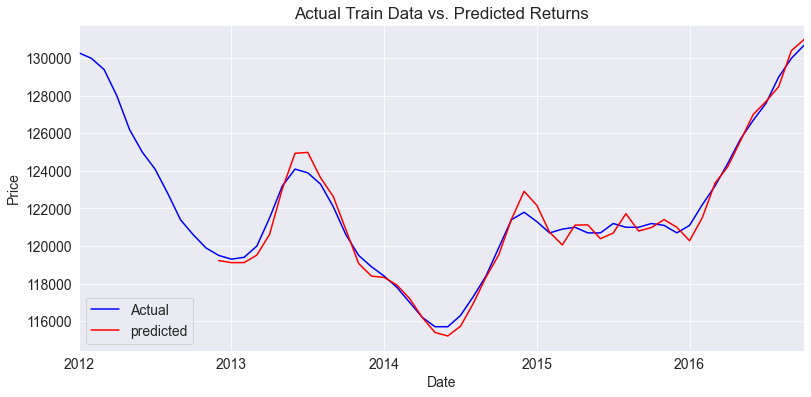

In [49]:
train_error(train, model)

ARIMA model RMSE on test data: 2447.33871


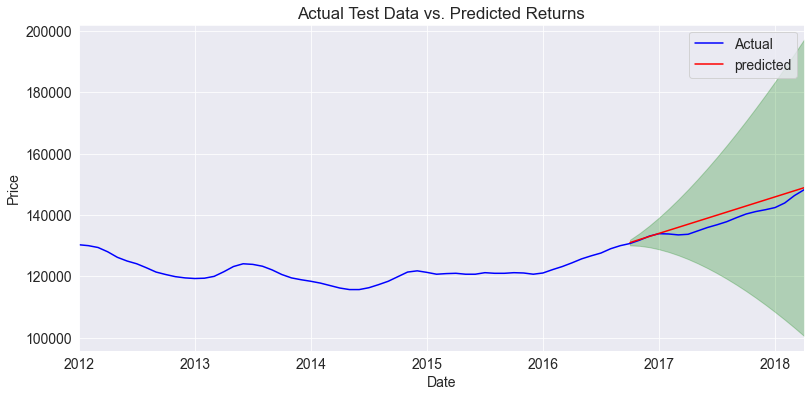

In [50]:
rmse = test_error(ts_19136, test, model)

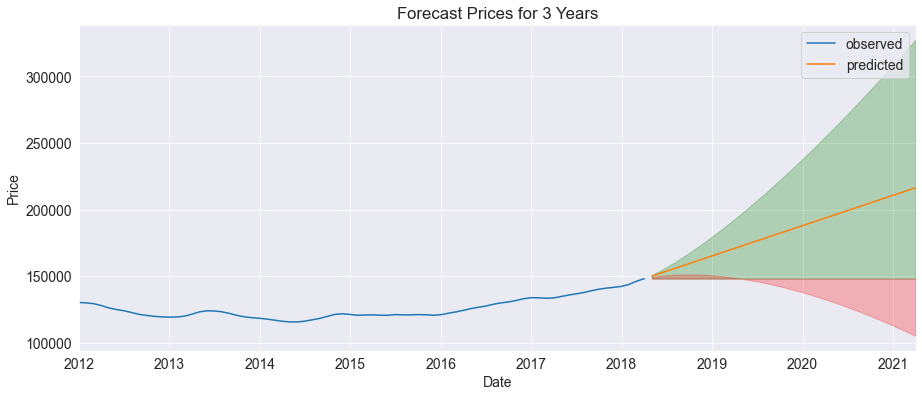

Return on investment after 1, 2, 3 years: 15.0%, 31.0%, 46.0%
Risk on investment after 1, 2, 3 years: -2.0%, 13.0%, 19.0%


In [51]:
roi1, roi2, roi3, risk1, risk2, risk3 = forecast(ts_19136, order=order)
print('Return on investment after 1, 2, 3 years: {}%, {}%, {}%'.format(round(roi1, 2)*100, 
                                                                       round(roi2, 2)*100, 
                                                                       round(roi3, 2)*100))
print('Risk on investment after 1, 2, 3 years: {}%, {}%, {}%'.format(round(risk1, 2)*100, 
                                                                     round(risk2, 2)*100, 
                                                                     round(risk3, 2)*100))

I was able to get better residuals out of our model, but the testing error is worse. We will stick with the model supplied by our helper functions.  This zipcode strikes me as one of the safer ones to invest in, and I would advise doing so.

# Summary

All 5 of our top zipcodes have potential, and I would recommend investing in four of them.  Zipcodes 19142, 19124, 19119, and 19136 all seem to offer high returns, especially for a short term investment while having manageable risks.  19142 and 19124 are particularly worth looking into as the prices of homes there are cheaper compared to the other zipcodes. Our model for zipcode 19131 did not perform well enough for me to recommend investing there, though the predictions show similar reults to the other zip codes.


# Future Work

Moving forward, I would bring in other features to the data set to see if we can refine the fit on our models. Using financial (tax rates, income levels) or social (school districts, crime rates) information as predictors would allow further tuning of our model. I would also consider using some different types of models like SARIMA to see if we can get better results for some of our potentially high ROI zipcodes. Or we could also use a nueral network to try to get a more powerful model. For now though, we have identified some good opportunities for investment!